In [1]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
# Make a dataframe accessible for util functions. WARNING: do not print this
EMPTY_DF = vaex.dataframe.DataFrame()

## Operations

In [3]:
# NOTE: 27 is only available as noext
AVAIL_HALO = [6, 16, 21, 23, 24, 27]

### Converting Metallicity

In [4]:
# Computed from a fit in another notebook
@vaex.register_function(on_expression=False)
def feh_from_z(z, a=1.0116, b=-0.1457):
    return z*a + b

### Open Metadata

In [5]:
import h5py

def read_metadata(filename):
    metadata = {}
    with h5py.File(filename) as f:
        for k, v in f["/Parameters"].items():
            metadata[k] = v[()]
    return metadata
    
# testing
dat = read_metadata("./data/mocks/ICC_ext_Au06-meta.hdf5")
dat

{'ErrorMonth': 22.0,
 'ErrorType': b'GaiaError',
 'ExtinctionType': b'NoExtinction',
 'IMF': b'chabrier',
 'apparent_mag_band': b'V',
 'apparent_mag_limit': 20.0,
 'apply_disk_cut': 1,
 'disk_cut_band': b'V',
 'disk_cut_latitude': 20.0,
 'disk_cut_limit': 16.0,
 'solarazimuth': 30.0,
 'solarheight': 2e-05,
 'solarradius': -0.008000000000000002,
 'usun': 11.1,
 'vlsr': 229.22258164519482,
 'vsun': 12.24,
 'wsun': 7.25}

### Deredden

In [6]:
def deredden(halo):
    # Deredden
    VtoG = 0.718
    VtoBP = 0.9875
    VtoRP = 0.576

    halo["GabsMagnitudeDR"] = halo["GabsMagnitude"] - halo["Extinction31"]*VtoG
    halo["GmagnitudeDR"] = halo["Gmagnitude"] - halo["Extinction31"]*VtoG
    halo["GBmagnitudeDR"] = halo["GBmagnitude"] - halo["Extinction31"]*VtoBP
    halo["GRmagnitudeDR"] = halo["GRmagnitude"] - halo["Extinction31"]*VtoRP
    
    halo["GabsMagnitudeDRObs"] = halo["GabsMagnitudeObs"] - halo["Extinction31"]*VtoG
    halo["GmagnitudeDRObs"] = halo["GmagnitudeObs"] - halo["Extinction31"]*VtoG
    halo["GBmagnitudeDRObs"] = halo["GBmagnitudeObs"] - halo["Extinction31"]*VtoBP
    halo["GRmagnitudeDRObs"] = halo["GRmagnitudeObs"] - halo["Extinction31"]*VtoRP

### GSR Correction

In [7]:
# Taken from: https://docs.astropy.org/en/stable/generated/examples/coordinates/rv-to-gsr.html?highlight=local%20standard%20of%20rest
import astropy.coordinates as coord
from astropy import units as u

def rv_to_gsr(c, v_sun=None):
    """Transform a barycentric radial velocity to the Galactic Standard of Rest
    (GSR).

    The input radial velocity must be passed in as a

    Parameters
    ----------
    c : `~astropy.coordinates.BaseCoordinateFrame` subclass instance
        The radial velocity, associated with a sky coordinates, to be
        transformed.
    v_sun : `~astropy.units.Quantity`, optional
        The 3D velocity of the solar system barycenter in the GSR frame.
        Defaults to the same solar motion as in the
        `~astropy.coordinates.Galactocentric` frame.

    Returns
    -------
    v_gsr : `~astropy.units.Quantity`
        The input radial velocity transformed to a GSR frame.

    """
    if v_sun is None:
        v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()

    gal = c.transform_to(coord.Galactic)
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()

    v_proj = v_sun.dot(unit_vector)

    return c.radial_velocity + v_proj

In [8]:
# https://docs.astropy.org/en/stable/coordinates/velocities.html#radial-velocity-corrections
@vaex.register_function()
def correct_radial_gsr(ra, dec, v_r, usun, vsun, wsun, lsr):
    # Construct the SkyCoord object
    c = coord.SkyCoord(ra*u.rad,
                 dec*u.rad,
                 frame='icrs',
                 radial_velocity=v_r * u.km / u.s,
                )
    
    v_sun = u.Quantity([usun, vsun + lsr, wsun], unit='km/s')    
    v_sun = coord.CartesianRepresentation(v_sun)
    
    v_gsr = rv_to_gsr(c, v_sun=v_sun)
    return v_gsr.value

### Observational Selections

In [9]:
import csv


def read_pointings(filename):
    ls = []
    bs = []
    with open(filename, 'r') as f:
        reader = list(csv.reader(f))
        for line in reader[1:]:
            l, b = line
            ls.append(float(l.strip()))
            bs.append(float(b.strip()))

    ls = np.array(ls)
    bs = np.array(bs)
    return ls, bs


@vaex.register_function(on_expression=False)
def sky_angle(c_l, c_b, l, b):
    """
    Computes the angular separation (in degrees) between a point (c_l, c_b) and
    the points in the columns l and b (galactic coordinates).
    """
    center = coord.SkyCoord(c_l, c_b, unit=u.deg, frame='galactic')
    coords = coord.SkyCoord(l, b, unit=u.deg, frame='galactic')
    return center.separation(coords).to(u.deg).value


@vaex.register_function()
def min_columns(c1, *cols):
    """
    Computes the minimum value of all the given columns. At least one column has
    to be given (c1)
    """
    minimum = c1
    for c in cols:
        minimum = np.minimum(minimum, c)
    return minimum


def fields_selection_columns(df, pointings_fn='./data/fieldcenters_spec.csv'):
    # Read in the field centers
    ls, bs = read_pointings(pointings_fn)

    # Compute the angular separation between each point
    for i, (l, b) in enumerate(zip(ls, bs)):
        df[f'Point{i}Separation'] = df.func.sky_angle(l, b, df.l, df.b)

    # Get the minimal distance to any of the field points 
    points = [f"Point{i}Separation" for i in range(len(ls))]
    df['MinFieldDistance'] = df.func.min_columns(
        *[getattr(df, p) for p in points])

In [10]:
def fields_selection():
    return "MinFieldDistance < 1"

In [11]:
def observational_selection(logg_min=1.8,
                            logg_max=3.2,
                            col_cut_min=0.4,
                            col_cut_max=1.4,
                            g_mag_min=13.5,
                            g_mag_max=16.5,
                            parallax_max=0.00025, # ~4kpc
                            obs=False,
                            fields=False):
    obs_str = "Obs" if obs else ""
    
    sel = ""
    sel += f"(SurfaceGravity > {logg_min}) & (SurfaceGravity < {logg_max}) "
    sel += f"& (Parallax{obs_str} < {parallax_max})"
    
    sel += f"& (GBmagnitudeDR{obs_str} - GRmagnitudeDR{obs_str} > {col_cut_min}) "
    sel += f"& (GBmagnitudeDR{obs_str} - GRmagnitudeDR{obs_str} < {col_cut_max}) "
    sel += f"& (Gmagnitude{obs_str} > {g_mag_min}) & (Gmagnitude{obs_str} < {g_mag_max})"
    if fields:
        sel += f"& ({fields_selection()})"
    
    return sel

In [12]:
def bulge_selection(radius=4):
    sel = f'sqrt( PosGCX**2 + PosGCY**2 + PosGCZ**2 ) < {radius}'
    return sel

In [13]:
def bulge_selection_2(radius=4, z=3):
    sel = f'(sqrt( PosGCX**2 + PosGCY**2) < {radius}) & (abs(PosGCZ) < {z})'
    return sel

## Computations

### Statistics

In [14]:
def velocity_stats(halos,
                   bins=None,
                   v_r_argument="RadialVelocityGSR",
                   obs=False,
                   selection_str=None,
                   selection_exp='Fe_H'):

    if not bins:
        bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]

    obs_str = "Obs" if obs else ""
    limits = [-12, 12]
    shape = 20

    result = {}
    for h_nr, h in halos.items():
        result[h_nr] = {
            "mean": [],
            "std": [],
            "N": [],
            "std_all": None,
            "N_all": None,
            "bins": bins,
            "l_space": h.bin_centers('', limits, shape),
            "fe_space": h.bin_centers('', (-3.0, 0), 10),
        }

        params = {
            'binby': 'Fe_H',
            'limits': [-3, 0],
            'shape': 10,
            'selection': selection_str,
        }
        result[h_nr]["std_all"] = h.std(f"{v_r_argument}{obs_str}", **params)
        result[h_nr]["N_all"] = h.count(**params)

        for b in bins:
            selection = f'({selection_exp} <= {b[1]}) & ({selection_exp} > {b[0]})'
            if selection_str is not None:
                selection += " & " + selection_str

            params = {
                'binby': 'l_wrap',
                'limits': limits,
                'shape': shape,
                'selection': selection
            }

            means = h.mean(f"{v_r_argument}{obs_str}", **params)
            stds = h.std(f"{v_r_argument}{obs_str}", **params)
            Ns = h.count(**params)
            result[h_nr]["mean"].append(means)
            result[h_nr]["std"].append(stds)
            result[h_nr]["N"].append(Ns)

    return result

### Fitting

In [15]:
from math import sqrt

def wsummed_values(x, y, w=None):
    """
    Function to calculate the, possibly weighted, sum values from x and y.
    """
    if w is None:
        w = 1
        S = x.size
    else:
        S = w.sum()
    Sx = (w*x).sum()
    Sy = (w*y).sum()
    Sxx = (w*x*x).sum()
    Syy = (w*y*y).sum()
    Sxy = (w*x*y).sum()
    return S, Sx, Sy, Sxx, Syy, Sxy

def chisquared(x, y, model):
    return ((y - model)**2 / model).sum()


def weighted_fit(x, y, y_err):
    """
    Finds the parameters a, b (and errors) for the model y = ax + b
    Uses the errors y_err in y to derive the weights for the model.
    """
    w = 1 / (y_err*y_err)
    S, Sx, Sy, Sxx, _, Sxy = wsummed_values(x, y, w)
    delta = S*Sxx - Sx*Sx
    
    a = (S*Sxy - Sx*Sy)/delta
    b = (Sxx*Sy - Sx*Sxy)/delta
    
    a_var = S / delta
    b_var = Sxx / delta
    
    chisq = chisquared(x, y, a*x + b)
    
    return a, b, sqrt(a_var), sqrt(b_var), chisq

In [16]:
def fit_slope_model(x, y):
    """
    Finds the slope (and its error) for the simple model y = ax.
    
    Copied from PROGNUM implementation
    """
    Sxx = (x*x).sum()
    a = (x*y).sum() / Sxx
    
    r = y - (a*x)
    var = (r*r).sum()/(len(x)-1)
    a_err = var/Sxx
    
    return a, np.sqrt(a_err)


In [17]:
def fit_flatness(halo_stats, bins=None):
    if not bins:
#         bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]
        k = list(halo_stats.keys())[0]
        bins = halo_stats[k]["bins"]

    fits = {}
    for i, h_num in enumerate(halo_stats.keys()):
        fits[h_num] = np.zeros((len(bins), 2), dtype=np.double)
        l_space = halo_stats[h_num]["l_space"]
        
        for j, b in enumerate(bins):
            mean = halo_stats[h_num]["mean"][j]
            std = halo_stats[h_num]["std"][j]
            N = halo_stats[h_num]["N"][j]
            
            y_err = std / N
            filled_bins = (N > 1) # NOTE: discuss?
            
#             res = weighted_fit(l_space[filled_bins], mean[filled_bins], y_err[filled_bins])
            res = fit_slope_model(l_space[filled_bins], mean[filled_bins])
            
            fits[h_num][j] = res

    return fits

## Plotting

### Stat based

Uncertainties in std
$$s\sqrt{ \frac{n-1}{\chi^2_R}} < \sigma < s\sqrt{ \frac{n-1}{\chi^2_L}}.$$

In [18]:
def plot_velocity_means(halo_stats,
                        obs=False,
                        bins=None,
                        l_space=None,
                        figax=None,
                        plot_text=True):
    """
    Input the stats like the following dictionary:
    {
        halo_nr : {
            # List of l bins per fe_bin
            "mean": [[...], ...],
            "std": [[...], ...],
            "N": [[...], ...],
        },
        ...
    }
    """
    if not bins:
        #         bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]
        k = list(halo_stats.keys())[0]
        bins = halo_stats[k]["bins"]

    n_halo = len(halo_stats)

    if l_space is None:
        l_space = EMPTY_DF.bin_centers('', (-12, 12), 20)

    if figax is None:
        figax = plt.subplots(n_halo,
                             len(bins),
                             figsize=(11, 2 * n_halo),
                             sharex=True,
                             sharey=True,
                             squeeze=False,
                             constrained_layout=True)

    fig, axs = figax

    for i, h_num in enumerate(halo_stats.keys()):
        bins = halo_stats[h_num]["bins"]
        for j, b in enumerate(bins):
            mean = halo_stats[h_num]["mean"][j]
            std = halo_stats[h_num]["std"][j]
            N = halo_stats[h_num]["N"][j]

            mean_err = std / np.sqrt(N)
            avg_bin = np.mean(N)

            ax = axs[i][j]
            ax.errorbar(l_space,
                        mean,
                        yerr=mean_err,
                        marker='.',
                        ls=' ',
                        label=f"Au{h_num:02d}")

            lim = 120
            ax.set_ylim(-lim, lim)
            ax.set_xlim(-12, 12)
            ax.axhline(0, ls='-.', c='gray', alpha=0.5)
            ax.tick_params(axis='y', direction='in')
            ax.tick_params(axis='x', direction='in')

            if plot_text:
                ax.text(0.05,
                        0.05,
                        r"$\overline{N}_{\rm}$ = " + f"{avg_bin:.0f}",
                        transform=ax.transAxes,
                        bbox={
                            'boxstyle': 'square',
                            'fc': 'white',
                            'ec': 'white',
                            'alpha': 0.5,
                        })

            if i == 0:
                ax.set_title(f"{b[0]} < [Fe/H] < {b[1]}")

        ax = axs[i][0]

        ax.set_ylabel(r'$\overline{v}_{\rm gsr}$ (km/s)')
        ax.invert_xaxis()
        if plot_text:
            ax.text(.95,
                    .95,
                    f"Au{h_num:02d}",
                    ha='right',
                    va='top',
                    transform=ax.transAxes,
                    fontweight='bold',
                    bbox={
                        'boxstyle': 'square',
                        'fc': 'white',
                        'ec': 'white',
                        'alpha': 0.7,
                    })

    for ax in axs[-1]:
        ax.set_xlabel('l (deg)')

#     fig.tight_layout(w_pad=0, h_pad=0)
    fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)

    return fig, axs


# figax = plot_velocity_means({6: data[6]})
# figax = plot_velocity_means(data)

In [19]:
from scipy.stats import chi2


def plot_velocity_dispersions(halo_stats,
                              obs=False,
                              bins=None,
                              l_space=None,
                              figax=None,
                              plot_text=True):
    """
    Input the stats like the following dictionary:
    {
        halo_nr : {
            # List of l bins per fe_bin
            "mean": [[...], ...],
            "std": [[...], ...],
            "N": [[...], ...],
        },
        ...
    }
    """
    if not bins:
        bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]
        k = list(halo_stats.keys())[0]
        bins = halo_stats[k]["bins"]

    n_halo = len(halo_stats)

    if l_space is None:
        l_space = EMPTY_DF.bin_centers('', (-12, 12), 20)

    if figax is None:
        figax = plt.subplots(n_halo,
                             len(bins),
                             figsize=(11, 2 * n_halo),
                             sharex=True,
                             sharey='row',
                             squeeze=False,
                             constrained_layout=True)
    fig, axs = figax

    # using 68%
    q = (1 - 0.68) / 2

    for i, h_num in enumerate(halo_stats.keys()):
        for j, b in enumerate(bins):
            mean = halo_stats[h_num]["mean"][j]
            std = halo_stats[h_num]["std"][j]
            N = halo_stats[h_num]["N"][j]

            df = N - 1  # degrees of freedom
            chi2_l, chi2_r = chi2.ppf(np.array([q, 1 - q])[:, np.newaxis],
                                      df=df)

            std_err_l = std * np.sqrt(1 / chi2_l)
            std_err_r = std * np.sqrt(1 / chi2_r)

            avg_bin = np.mean(N)

            ax = axs[i][j]
            ax.errorbar(l_space,
                        std,
                        yerr=(std_err_l, std_err_r),
                        marker='.',
                        ls=' ',
                        label=f"Au{h_num:02d}")

            ax.set_xlim(-12, 12)
            ax.tick_params(axis='y', direction='in')
            ax.tick_params(axis='x', direction='in')

            if plot_text:
                ax.text(0.05,
                        0.05,
                        r"$\overline{N}_{\rm}$ = " + f"{avg_bin:.0f}",
                        transform=ax.transAxes,
                        bbox={
                            'boxstyle': 'square',
                            'fc': 'white',
                            'ec': 'white',
                            'alpha': 0.5,
                        })

            if i == 0:
                ax.set_title(f"{b[0]} < [Fe/H] < {b[1]}")

        ax = axs[i][0]

        ax.set_ylabel(r'$\sigma(v_{\rm gsr})$ (km/s)')
        
        bot, top = ax.get_ylim()
        bot = max(bot, 50)
        ax.set_ylim(bot, top)
        
        ax.invert_xaxis()
        if plot_text:
            ax.text(.95,
                    .95,
                    f"Au{h_num:02d}",
                    ha='right',
                    va='top',
                    transform=ax.transAxes,
                    fontweight='bold',
                    bbox={
                        'boxstyle': 'square',
                        'fc': 'white',
                        'ec': 'white',
                        'alpha': 0.7,
                    })

    for ax in axs[-1]:
        ax.set_xlabel('l (deg)')

#     fig.tight_layout(w_pad=0, h_pad=0)
    fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)

    return fig, axs

# figax = plot_velocity_dispersions({6: data[6]})
# figax = plot_velocity_means(data)
# figax = plot_velocity_dispersions(data)

In [20]:
def plot_bin_sizes(halo_stats,
                   figax=None,
                   bins=None,
                   l_space=None,
                   last_n_bins=2):
    if not bins:
        bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]
        k = list(halo_stats.keys())[0]
        bins = halo_stats[k]["bins"]

    # Only do this for the last few bins
    total_bins = len(bins)
    bins = bins[-last_n_bins:]

    n_halo = len(halo_stats)

    if l_space is None:
        l_space = EMPTY_DF.bin_centers('', (-12, 12), 20)

    if figax is None:
        figax = plt.subplots(len(bins),
                             n_halo,
                             figsize=(2 * n_halo, 2 * len(bins)),
                             sharex=True,
                             sharey='row',
                             squeeze=False)
    fig, axs = figax
    # Apply some stuff to all axes
    ax = axs[0][0]
    width = l_space[1] - l_space[0]

    for j, b in enumerate(bins):
        for i, h_num in enumerate(halo_stats.keys()):
            N = halo_stats[h_num]["N"][j - last_n_bins]

            ax = axs[j][i]

            ax.bar(l_space, N, width=width, edgecolor='k')
            ax.axhline(N.mean(), ls='--', c='tab:orange')
            if j == 0:
                ax.set_title(f'Au{h_num:02d}')

        ax = axs[j][0]
        ax.set_ylabel(f"N for [{b[1]}, {b[0]}]")

    last_row = axs[-1]
    for ax in last_row:
        ax.set_xlabel('l (deg)')

    ax = axs[0][0]
    ax.set_xlim(-12, 12)
    ax.invert_xaxis()

    fig.tight_layout()

In [21]:
def plot_fe_dispersions(halo_stats,
                        obs=False,
                        bins=None,
                        l_space=None,
                        figax=None,
                        plot_text=True):
    if figax is None:
        figax = plt.subplots(1, 1)
    fig, ax = figax
    
    q = (1 - 0.68) / 2
    
    for h_nr, h in halo_stats.items():
        std = h["std_all"]
        N = h["N_all"]
        fe = h["fe_space"]
        
        df = N - 1  # degrees of freedom
        chi2_l, chi2_r = chi2.ppf(np.array([q, 1 - q])[:, np.newaxis],
                                  df=df)

        std_err_l = std * np.sqrt(1 / chi2_l)
        std_err_r = std * np.sqrt(1 / chi2_r)

        avg_bin = np.mean(N)
        
        ax.errorbar(fe,
                    std,
                    yerr=(std_err_l, std_err_r),
                    marker='o',
                    ls=':',
                    label=f"Au{h_nr:02d}")

    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel(r'$\sigma(v_{\rm gsr})$ (km/s)')
    ax.set_xlim(-3, 0)
    
    ax.legend()
    fig.tight_layout()
    
    return figax
    
# plot_fe_dispersions(data)

### Fits

In [22]:
def plot_fits_lines(fits, halo_stats, figax, l_space=None, ls='--', c=None):
    """
    Overplots the fitted lines in the mosaic figure
    """
    # TODO: add option for automatic figax creation
    if l_space is None:
        l_space = EMPTY_DF.bin_centers('', (-12, 12), 20)

    fig, axs = figax
    for axl, (h_nr, halo) in zip(axs, halo_stats.items()):
        for fit, ax in zip(fits[h_nr], axl):
            a, _ = fit
            ax.plot(l_space, a*l_space, ls=ls, c=c)

In [23]:
def plot_fits(fits, bins=None, figax=None):
    """
    Plots all the slopes of the fit in a single figure.
    """
    if not bins:
        bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]

    if figax is None:
        figax = plt.subplots(1, 1)

    fig, ax = figax

    bin_axis = np.arange(len(bins))
    for h_nr, fit in fits.items():
        ax.errorbar(bin_axis, fit[:, 0], yerr=fit[:, 1], label=f"Au{h_nr:d}", ls=':', marker='o')

    bin_labels = [f"{b[1]} to {b[0]}" for b in bins]
    ax.set_xticks(bin_axis)
    ax.set_xticklabels(bin_labels)
    ax.set_ylabel('R (slope)')
    ax.set_xlabel('[Fe/H]')
    ax.legend()
    fig.tight_layout()
    return figax

# plot_fits(fits)
# plt.show()

### Computation based

In [24]:
def plot_vel_dispersions(halos, v_r_argument="RadialVelocityGSR", obs=False, selection=None):
    fig, ax = plt.subplots(1, 1)
    
    obs_str = "Obs" if obs else ""
    
    for h_nr, h in halos.items():
        std = h.std(f"{v_r_argument}{obs_str}", binby='Fe_H', limits=[-3, -0.5], shape=10, selection=selection)
        
        x_space = np.linspace(-3, -0.5, 10)
        label = f"Au{h_nr}"
        
        ax.plot(x_space, std, label=label, marker='.')

    ax.set_ylabel(r"[Fe/H]")
    ax.set_ylabel(r'std $V_r$ (km/s)')
    ax.legend()

In [25]:
def plot_velocities_together(halos,
                             fe_bins=None,
                             v_r_argument="RadialVelocityGSR",
                             obs=False,
                             selection_str=None):
    fig, axs = plt.subplots(2, 4, figsize=(11, 5), sharex=True)
    obs_str = "Obs" if obs else ""

    if not fe_bins:
        fe_bins = [[-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]

    # Iterate over halos
    for h_nr, h in halos.items():
        # Iterate over bins
        for i, b in zip(range(len(axs[0])), fe_bins):

            selection = f'(Fe_H <= {b[1]}) & (Fe_H > {b[0]})'
            if selection_str is not None:
                selection += " & " + selection_str

            params = {
                'binby': 'l_wrap',
                'limits': [-12, 12],
                'shape': 20,
                'selection': selection
            }

            means = h.mean(f"{v_r_argument}{obs_str}", **params)
            std = h.std(f"{v_r_argument}{obs_str}", **params)
            N = h.count(**params)

            yerr = std / np.sqrt(N)
            avg_bin = np.mean(N)

            ax = axs[0][i]
            ax_s = axs[1][i]

            l_space = np.linspace(*params['limits'], params['shape'])

            label = f"Au{h_nr}"
            ax_s.plot(l_space, std, label=label, marker='.')
            ax.errorbar(l_space, means, yerr=yerr, label=label, marker='.')

            ax.set_title(f"[Fe/H] = {b[1]} to {b[0]}")
            ax_s.set_xlabel('l (deg)')

            if i > 0:
                ax.set_yticklabels([])
                ax_s.set_yticklabels([])

            ax.set_ylim(-70, 70)
            ax_s.set_ylim(150, 200)

        axs[0][0].set_ylabel(r'mean $V_r$ (km/s)')
        axs[0][0].invert_xaxis()
        axs[1][0].set_ylabel(r'std $V_r$ (km/s)')
        axs[1][0].legend()

        fig.tight_layout()

In [26]:
def plot_velocities(df,
                    fe_bins=None,
                    v_r_argument="RadialVelocityGSR",
                    obs=False,
                    selection_str=None):

    fig, axs = plt.subplots(2, 4, figsize=(11, 5), sharex=True)
    obs_str = "Obs" if obs else ""

    if not fe_bins:
        fe_bins = [[-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]

    for i, b in zip(range(len(axs[0])), fe_bins):

        selection = f'(Fe_H <= {b[1]}) & (Fe_H > {b[0]})'
        if selection_str is not None:
            selection += " & " + selection_str
            
        params = {
            'binby': 'l_wrap',
            'limits': [-12, 12],
            'shape': 20,
            'selection': selection
        }

        means = df.mean(f"{v_r_argument}{obs_str}", **params)
        std = df.std(f"{v_r_argument}{obs_str}", **params)
        N = df.count(**params)

        yerr = std / np.sqrt(N)
        avg_bin = np.mean(N)

        ax = axs[0][i]
        ax_s = axs[1][i]

        l_space = np.linspace(*params['limits'], params['shape'])

        label = "Observed" if obs else "Simulated"
        ax_s.plot(l_space, std, label=label, ls=' ', marker='o')
        ax.errorbar(l_space, means, yerr=yerr, label=label, ls=' ', marker='o')

        ax.text(-10, -60, f"avg bin size = {avg_bin:.0f}")

        ax.set_title(f"[Fe/H] = {b[1]} to {b[0]}")
        ax_s.set_xlabel('l (deg)')
        ax.invert_xaxis()

        if i > 0:
            ax.set_yticklabels([])
            ax_s.set_yticklabels([])

        ax.set_ylim(-70, 70)
        ax_s.set_ylim(150, 200)

    axs[0][0].set_ylabel(r'mean $V_r$ (km/s)')
    axs[1][0].set_ylabel(r'std $V_r$ (km/s)')

    fig.tight_layout()

    return fig, axs

### Exploratory plots

In [27]:
from functools import wraps


def ax_selector(func):
    def wrapper(df, ax=None, *args, **kwargs):
        if ax is None:
            _, ax = plt.subplots(1, 1)
        plt.sca(ax)

        func(df, ax, *args, **kwargs)

        return ax

    return wrapper


@ax_selector
def plot_count(df,
               ax=None,
               x='l_wrap',
               y='b',
               what='count(*)',
               colorbar_label='log (1+N)',
               selection=None,
               f='log1p',
               **kwargs):
    df.viz.heatmap('l_wrap',
                   'b',
                   what=what,
                   f=f,
                   selection=selection,
                   colorbar_label=colorbar_label,
                   **kwargs)

    ax.set_xlabel('l (deg)')
    ax.set_ylabel('b (deg)')
    return ax


@ax_selector
def plot_CMD(df, ax=None, selection=None, **kwargs):
    if 'colorbar_label' not in kwargs:
        kwargs['colorbar_label'] = 'log(N)'
    if 'colormap' not in kwargs:
        kwargs['colormap'] = 'YlOrBr'
    if 'f' not in kwargs:
        kwargs['f'] = 'log10'
        
    df.viz.heatmap('GBmagnitudeDR - GRmagnitudeDR',
                   '-GabsMagnitudeDR',
                   selection=selection,
                   **kwargs)

    return ax


@ax_selector
def plot_grav_teff(df, ax=None, selection=None, what='mean(Fe_H)'):
    df.viz.heatmap('EffectiveTemperature',
                   'SurfaceGravity',
                   what=what,
                   limits=[[4000, 7000], [0, 5]],
                   colormap='jet',
                   selection=selection,
                   colorbar_label='mean( [Fe/H] )')

    ax.set_ylabel(r'$\log g$')
    ax.set_xlabel(r'$T_{eff} (K)$')
    ax.invert_xaxis()
    ax.invert_yaxis()

    return ax


@ax_selector
def plot_xy_plane(df, ax=None):
    df.viz.heatmap('PosX', 'PosY', what='count(*)', f='log10')


def visualize_dataset(df):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    plot_count(df, axs[0])
    plot_CMD(df, axs[1])
    plot_grav_teff(df, axs[2])
    plot_xy_plane(df, axs[3])
    # todo: add another plot. X-Y plot maybe?

    return fig, axs

## Open function

In [28]:
def open_halo(halo_nr, ext=True, prefix='./data/mocks/', selection=True):
    ext_str = "ext" if ext else "noext"

    if prefix is None:
        prefix = ""

    # Reading
    data_filename = f"{prefix}ICC_{ext_str}_Au{halo_nr:02d}.hdf5"
    metadata_filename = f"{prefix}ICC_{ext_str}_Au{halo_nr:02d}-meta.hdf5"

    halo = vaex.open(data_filename)
    metadata = read_metadata(metadata_filename)

    # Cartesian coordinates centered on the galactic center
    # the sun is placed at (-8, 0, 0.02)
    halo['PosGCX'] = halo['PosX'] - 8
    halo['PosGCY'] = halo['PosY']
    halo['PosGCZ'] = halo['PosZ'] + 0.02

    # Correction for solar metallicity (FIND NEW SOURCE)
    halo['Z'] = np.log10(halo.Metallicity / 0.0153)
    halo["Fe_H"] = feh_from_z(halo["Z"])

    # Distance & absolute magnitudes
    halo['Distance'] = 1 / halo['Parallax']
    halo['GabsMagnitude'] = halo['Gmagnitude'] - 5 * np.log10(
        halo['Distance'] / 10)
    halo['GabsMagnitudeObs'] = halo['GmagnitudeObs'] - 5 * np.log10(
        halo['Distance'] / 10)

    # Dust correction
    deredden(halo)

    # GSR correction
    halo['RadialVelocityGSR'] = halo.func.correct_radial_gsr(
        halo.RA, halo.Dec, halo.RadialVelocity, metadata['usun'],
        metadata['vsun'], metadata['wsun'], metadata['vlsr'])
    halo['RadialVelocityGSRObs'] = halo.func.correct_radial_gsr(
        halo.RAObs, halo.DecObs, halo.RadialVelocityObs, metadata['usun'],
        metadata['vsun'], metadata['wsun'], metadata['vlsr'])

    # Compute field columns
    fields_selection_columns(halo)

    # Make selection
    if selection:
        halo = halo[(halo.Z < 0) & (halo.Z > -5)]

    return halo, metadata

## Loading & plotting halos

In [29]:
halo = {}
mdata = {}

# change to AVAIL_HALO at some point
for h_nr in [6, 16, 21, 23, 24]:
    h, m = open_halo(h_nr, selection=True)
    halo[h_nr] = h
    mdata[h_nr] = m

print(f"Loaded {len(halo)} halos")
print(f"With a total of {sum(len(h) for h in halo.values())/1e6:.1f} million stars (filtered)")

Loaded 5 halos


/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/vaex/functions.py:95: RuntimeWarning: divide by zero encountered in log10
  result = function(*numpy_data, **kwargs)
/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/vaex/functions.py:95: RuntimeWarning: invalid value encountered in log10
  result = function(*numpy_data, **kwargs)


With a total of 7.6 million stars (filtered)


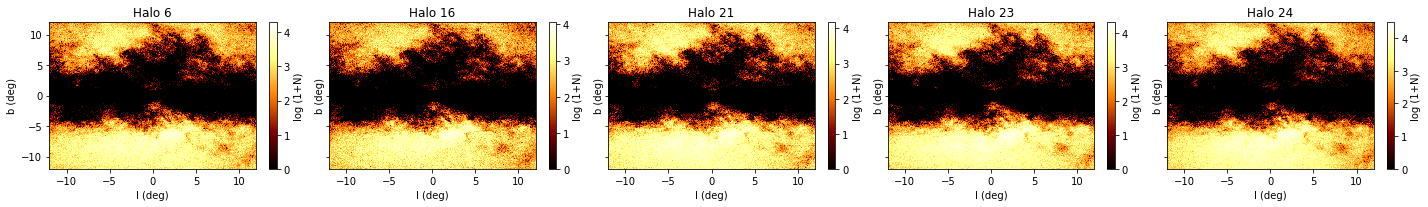

In [30]:
fig, axs = plt.subplots(1, len(halo), figsize=(4*len(halo), 3), sharex=True, sharey=True)
for (h_nr, h), ax in zip(halo.items(), axs.flatten()):
    plot_count(h, ax, selection=observational_selection())
    ax.set_title(f"Halo {h_nr}")

plt.show()

In [31]:
if False:
    fig, axs = plt.subplots(1, len(halo), figsize=(4*len(halo), 3), sharex=True, sharey=True)
    sel = observational_selection()
    for (h_nr, h), ax in zip(halo.items(), axs.flatten()):
        plot_count(h, ax, selection=sel)
        ax.set_title(f"Halo {h_nr}")

    plt.show()

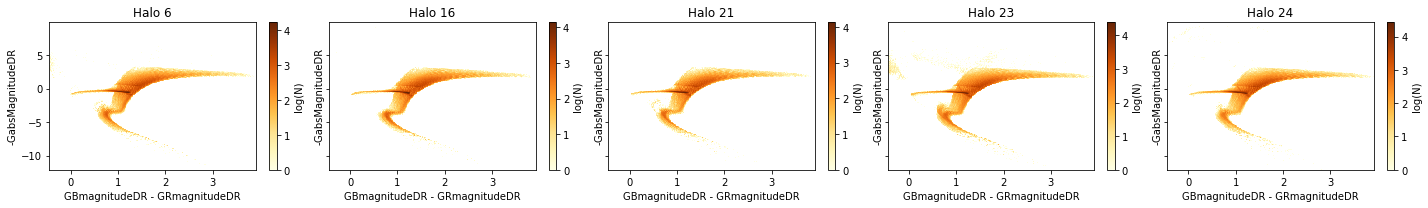

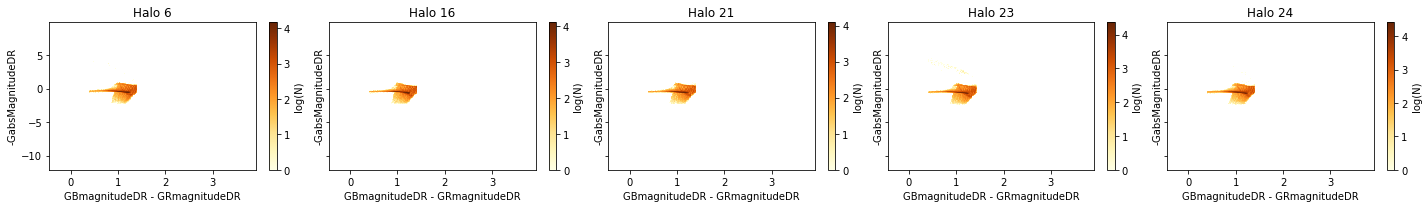

In [32]:
fig, axs = plt.subplots(1, len(halo), figsize=(4*len(halo), 3), sharex=True, sharey=True)
for (h_nr, h), ax in zip(halo.items(), axs.flatten()):
    plot_CMD(h, ax)
    ax.set_title(f"Halo {h_nr}")

plt.show()

fig, axs = plt.subplots(1, len(halo), figsize=(4*len(halo), 3), sharex=True, sharey=True)
for (h_nr, h), ax in zip(halo.items(), axs.flatten()):
    plot_CMD(h, ax, selection=observational_selection())
    ax.set_title(f"Halo {h_nr}")

plt.show()

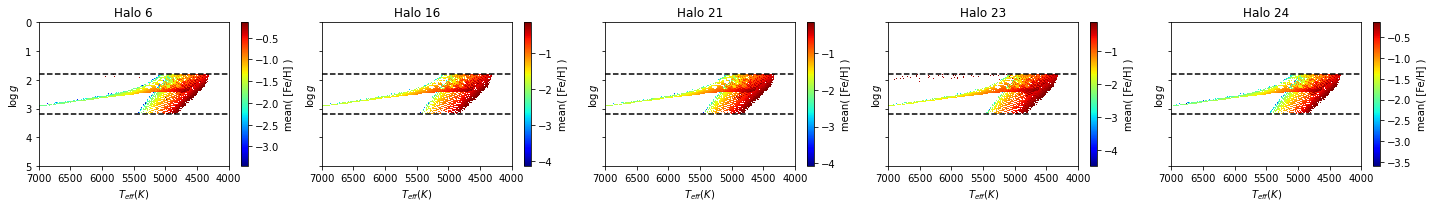

In [33]:
fig, axs = plt.subplots(1, len(halo), figsize=(4*len(halo), 3), sharex=True, sharey=True)
for (h_nr, h), ax in zip(halo.items(), axs.flatten()):
    plot_grav_teff(h, ax, selection=observational_selection())
    ax.set_title(f"Halo {h_nr}")
    ax.axhline(1.8, ls='--', c='k')
    ax.axhline(3.2, ls='--', c='k')

plt.show()

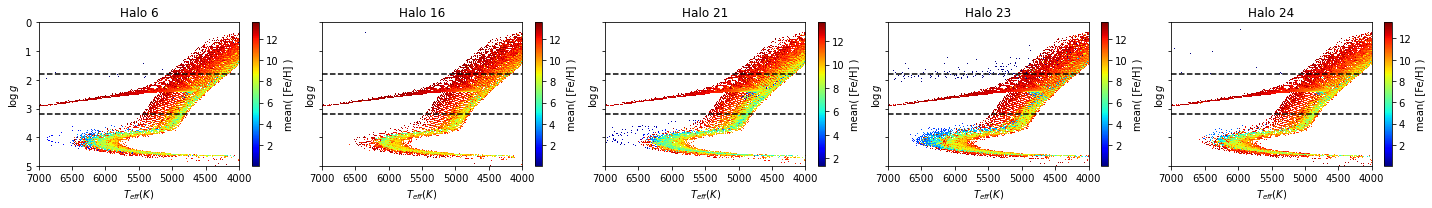

In [34]:
fig, axs = plt.subplots(1, len(halo), figsize=(4*len(halo), 3), sharex=True, sharey=True)
for (h_nr, h), ax in zip(halo.items(), axs.flatten()):
    plot_grav_teff(h, ax, what='mean(Age)')
    ax.set_title(f"Halo {h_nr}")
    ax.axhline(1.8, ls='--', c='k')
    ax.axhline(3.2, ls='--', c='k')

plt.show()

## Loading bar models

In [35]:
shen_models = {}
for i in [4, 6, 8]:
    model_fn = f"./data/bar_fits/model_velo_b-{i}.data"
    x = np.loadtxt(model_fn).T
    shen_models[i] = x

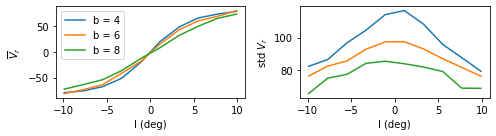

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2))
for i, x in shen_models.items():
    axs[0].plot(x[0], x[1], label=f"b = {i}")
    axs[1].plot(x[0], x[2], label=f"b = {i}")
    
axs[0].legend()
axs[0].set_xlabel('l (deg)')
axs[1].set_xlabel('l (deg)')
axs[0].set_ylabel(r'$\overline{V}_r$')
axs[1].set_ylabel(r'std $V_r$')
fig.tight_layout()
# axs[1].legend()
plt.show()

## Running
Rerun all...

In [37]:
import matplotlib

In [38]:
from pathlib import Path

def save_show(filename, base_dir='./figs/'):
    fn = Path(filename)
    base_dir = Path(base_dir)
    save_location = base_dir / fn
    print('Saving at', save_location)
    plt.savefig(save_location)
    plt.show()

In [39]:
import pathlib
import pickle

# TODO: revert force back!
def saveload(filename, *args, force=False, **kwargs):
    """
    Will run the velocity stats function if there is no file for it yet,
    otherwise will just read the file that exists already.
    This is essentially caching the result...
    
    Overwrite an existing file using the `force` flag.
    """
    filepath = pathlib.Path(filename)
    if force or not filepath.exists():
        print("Rerunning velocity stats...")
        with vaex.progress.tree('rich', title="Computing Radial Velocity Statistics"):
            data = velocity_stats(*args, **kwargs)
        with open(filename, 'wb') as f:
            pickle.dump(data, f)
    else:
        print("Using saved result...")
        with open(filename, 'rb') as f:
            data = pickle.load(f)
    return data

In [40]:
### results 1.
# All observational effects
sel = observational_selection(obs=True, fields=True)
data = saveload("./data/computed/obs_velocity_stats.pkl", halo, obs=True, selection_str=sel)

Using saved result...


In [41]:
### results 2.
# -12 to 12 field, with observational selections on true values
sel = observational_selection(obs=True)
data = saveload("./data/computed/all_obs_velocity_stats.pkl", halo, obs=True, selection_str=sel)

# -12 to 12 field, with observational selections on observed values
sel = observational_selection(obs=False)
data = saveload("./data/computed/all_true_velocity_stats.pkl", halo, selection_str=sel)

Using saved result...
Using saved result...


In [42]:
# Strips with observational selections on observed values
bs = [-4, -6, -8, -10, 6]
for n, b in enumerate(bs):
    sel = f"(b < {b+0.5}) & (b > {b-0.5}) & {observational_selection(obs=True)}"
    data = saveload(f"./data/computed/slice_{b}_obs_velocity_stats.pkl", halo, selection_str=sel)

Using saved result...
Using saved result...
Using saved result...
Using saved result...
Using saved result...


In [43]:
# -12 to 12 field with true positions and no other selections
sel = bulge_selection_2(4, z=1)
data = saveload("./data/computed/all_true_pos_velocity_stats.pkl",
                halo,
                selection_str=sel)

Using saved result...


In [44]:
# -12 to 12 field with true positions and no other selections
sel = bulge_selection_2(2, z=1)
data = saveload("./data/computed/all_true_pos_low_r_velocity_stats.pkl",
                halo,
                selection_str=sel)

Using saved result...


In [45]:
# ParticleID stuff on the -12 to 12 field, with true values
agg_halo = {}
for nr, h in halo.items():
    agg_halo[nr] = h.groupby(by='ParticleID').agg({
        'RadialVelocityGSR': 'mean',
        'Fe_H': 'first',
        'l_wrap': 'mean',
        'PosGCX': 'mean',
        'PosGCY': 'mean',
        'PosGCZ': 'mean',
    })
sel = bulge_selection_2(4, z=1)
data = saveload("./data/computed/pid_velocity_stats.pkl", agg_halo, selection_str=sel)

Using saved result...


In [46]:
# Accreted vs in-situ particles
sel = bulge_selection_2(4, z=1)
situ = saveload("./data/computed/insitu_velocity_stats.pkl", halo, selection_str=f'(AccretedFlag == -1) & {sel}')
accr = saveload("./data/computed/accreted_velocity_stats.pkl", halo, selection_str=f'(AccretedFlag == 0) & {sel}')

Using saved result...
Using saved result...


In [47]:
# Binned by age
sel = bulge_selection_2(4, z=1)
age_bins = [[4, 8], [8, 10], [10, 12], [12, 14]]
d = saveload("./data/computed/age_velocity_stats.pkl", halo, selection_str=sel, bins=age_bins, selection_exp='Age')

Using saved result...


In [48]:
# Binned by age, more bins
sel = bulge_selection_2(4, z=1)
age_bins = [[4, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14]]
d = saveload("./data/computed/age_2_velocity_stats.pkl", halo, selection_str=sel, bins=age_bins, selection_exp='Age')

Using saved result...


## Result Plots

### Recreating Observations

Using saved result...


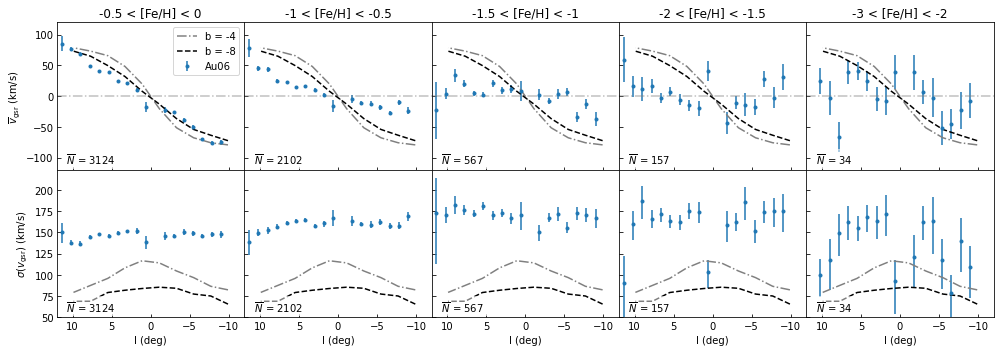

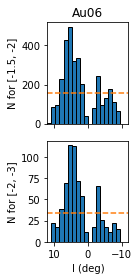

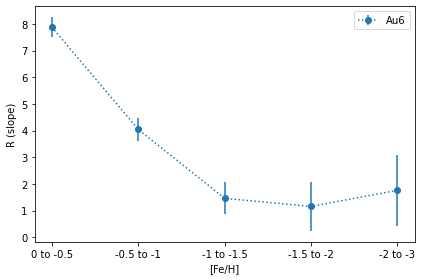

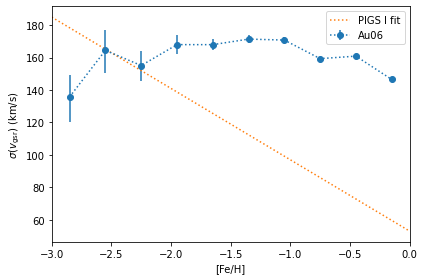

In [49]:
# TODO: make this into one plot
sel = observational_selection(obs=True, fields=True)
data = saveload("./data/computed/obs_velocity_stats.pkl", halo, obs=True, selection_str=sel)

# Only select Au6
data = {6: data[6]}
fits = fit_flatness(data)

fig_0, axs_0 = plt.subplots(2, 5, figsize=(14, 5), sharex=True, sharey='row')


figax = plot_velocity_means(data, figax=(fig_0, np.array([axs_0[0]])))
fig, axs = figax
# plot_fits_lines(fits, data, figax)
for ax in axs[0]:
    i = 4
    x = shen_models[i]
    ax.plot(x[0], x[1], label=f'b = -{i}', ls='-.', c='gray')
    
    i = 8
    x = shen_models[i]
    ax.plot(x[0], x[1], label=f'b = -{i}', ls='--', c='k')
axs[0,0].texts[-1].set_visible(False)
axs[0,0].legend()

fig, axs = plot_velocity_dispersions(data, figax=(fig_0, np.array([axs_0[1]])))

for ax in axs[0]:
    i = 4
    x = shen_models[i]
    ax.plot(x[0], x[2], label=f'b = -{i}', ls='-.', c='gray')
    
    i = 8
    x = shen_models[i]
    ax.plot(x[0], x[2], label=f'b = -{i}', ls='--', c='k')

for ax in axs_0[0]:
    ax.set_xlabel('')

for ax in axs_0[1]:
    ax.set_title('')
    
axs[0,0].texts[-1].set_visible(False)
    
fig.tight_layout(w_pad=0, h_pad=0)
plt.show()

plot_bin_sizes(data)
plt.show()

plot_fits(fits)
plt.show()

fig, ax = plot_fe_dispersions(data)
x = np.linspace(-3, 0)
y = -44*x + 53
ax.plot(x, y, ls=':', label='PIGS I fit')
ax.legend()


plt.show()

### Selection Effects for Au6

In [50]:
filenames = [
    "./data/computed/obs_velocity_stats.pkl", # 0
    "./data/computed/all_obs_velocity_stats.pkl", # 1
    "./data/computed/all_true_velocity_stats.pkl", # 3
    "./data/computed/all_true_pos_velocity_stats.pkl", # 4
    "./data/computed/pid_velocity_stats.pkl", # 5
#     "./data/computed/all_true_pos_low_r_velocity_stats.pkl", # 6
]

selection_nrs = [0, 1, 3, 4, 5]
selection_texts = ['Fields + Obs', 'Box + Obs', 'Box + True', 'Box + Pos', 'Box + Pos + SP']

comb_data = {}
for n, fn in zip(selection_nrs, filenames):
    # Only select Au6 for now
    comb_data[n] = saveload(fn, None)[6]

Using saved result...
Using saved result...
Using saved result...
Using saved result...
Using saved result...


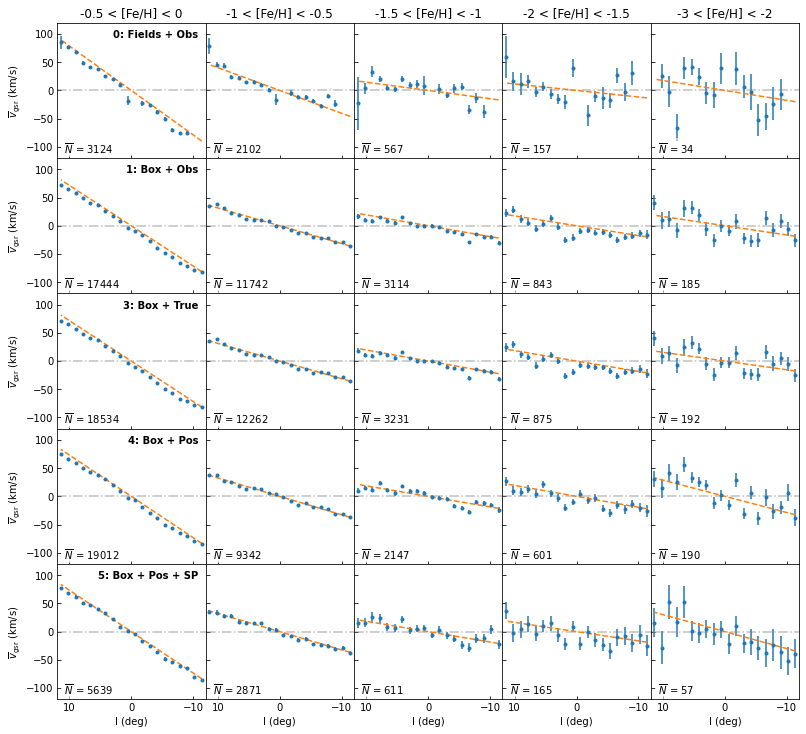

In [51]:
fits = fit_flatness(comb_data)
figax = plot_velocity_means(comb_data)
plot_fits_lines(fits, comb_data, figax=figax)
fig, axs = figax

for n, s_txt, ax in zip(selection_nrs, selection_texts, axs[:, 0]):
    txt = ax.texts[-1]
    txt.set_text(f"{n}: {s_txt}")
    txt.set_fontweight('bold')
plt.show()

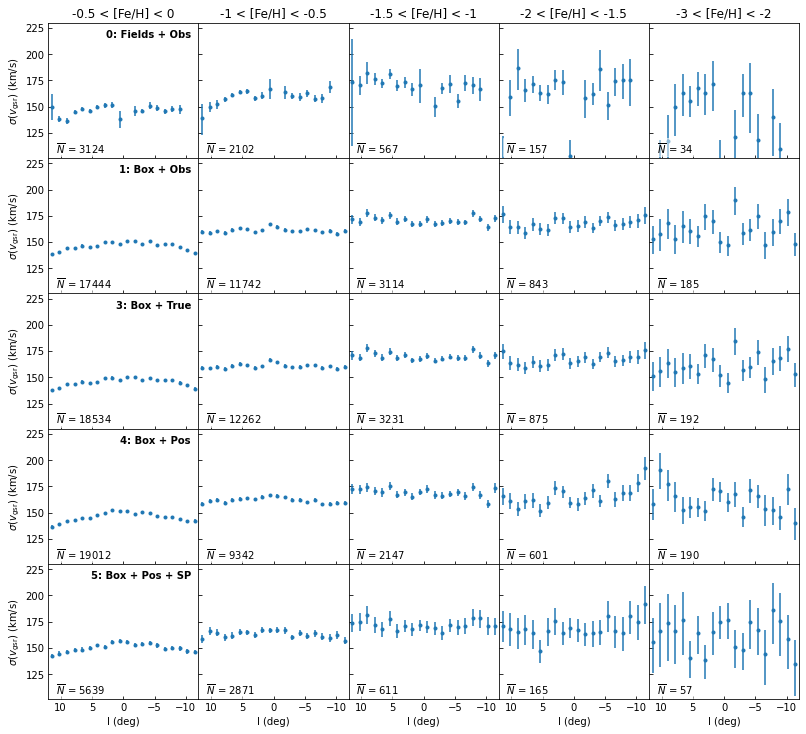

In [52]:
figax = plot_velocity_dispersions(comb_data)
fig, axs = figax

for n, s_txt, ax in zip(selection_nrs, selection_texts, axs[:, 0]):
    txt = ax.texts[-1]
    txt.set_text(f"{n}: {s_txt}")
    txt.set_fontweight('bold')
    
#     ax.set_ylim(101, 224)
    ax.set_ylim(101, 230)

plt.show()

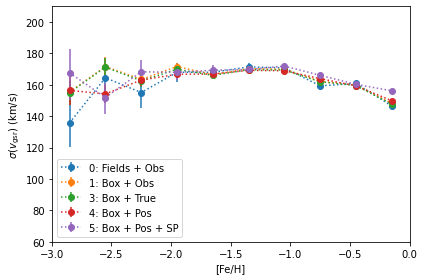

In [53]:
fig, ax = plot_fe_dispersions(comb_data)
ax.legend([f"{n}: {t}" for n, t in zip(selection_nrs, selection_texts)]) 
ax.set_ylim(60, 210)
plt.show()

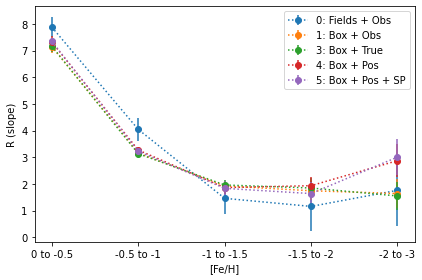

In [54]:
fig, ax = plot_fits(fits)
ax.legend([f"{n}: {t}" for n, t in zip(selection_nrs, selection_texts)]) 
plt.show()

In [55]:
# Strips with observational selections on observed values
bs = [-4, -6, -8, -10, 6]
strip_data = {}
for n, b in enumerate(bs):
    strip_data[b] = saveload(f"./data/computed/slice_{b}_obs_velocity_stats.pkl", None)[6]

Using saved result...
Using saved result...
Using saved result...
Using saved result...
Using saved result...


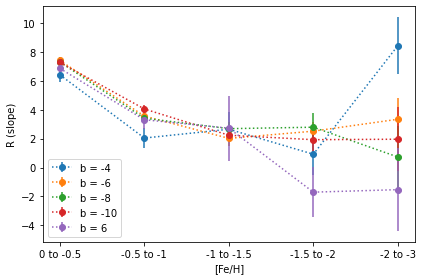

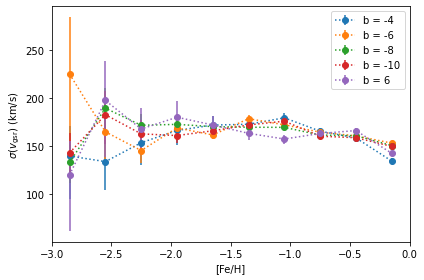

In [56]:
fits = fit_flatness(strip_data)
fig, ax = plot_fits(fits)
ax.legend([f"b = {n}" for n in bs]) 
plt.show()

fig, ax = plot_fe_dispersions(strip_data)
ax.legend([f"b = {n}" for n in bs]) 
plt.show()

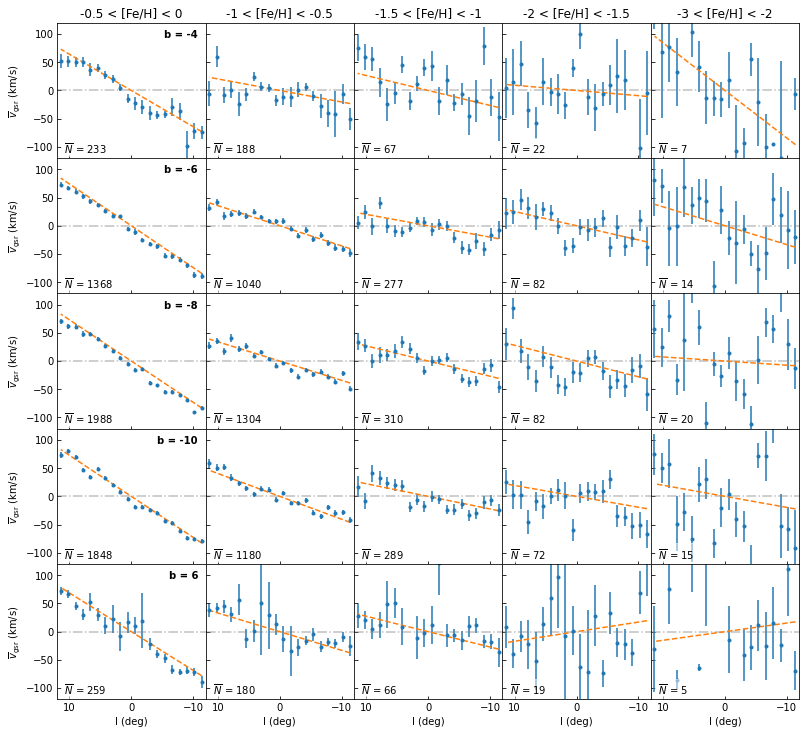

In [57]:
figax = plot_velocity_means(strip_data)
plot_fits_lines(fits, strip_data, figax=figax)
fig, axs = figax

for n, ax in zip(bs, axs[:, 0]):
    txt = ax.texts[-1]
    txt.set_text(f"b = {n}")
    txt.set_fontweight('bold')

plt.show()

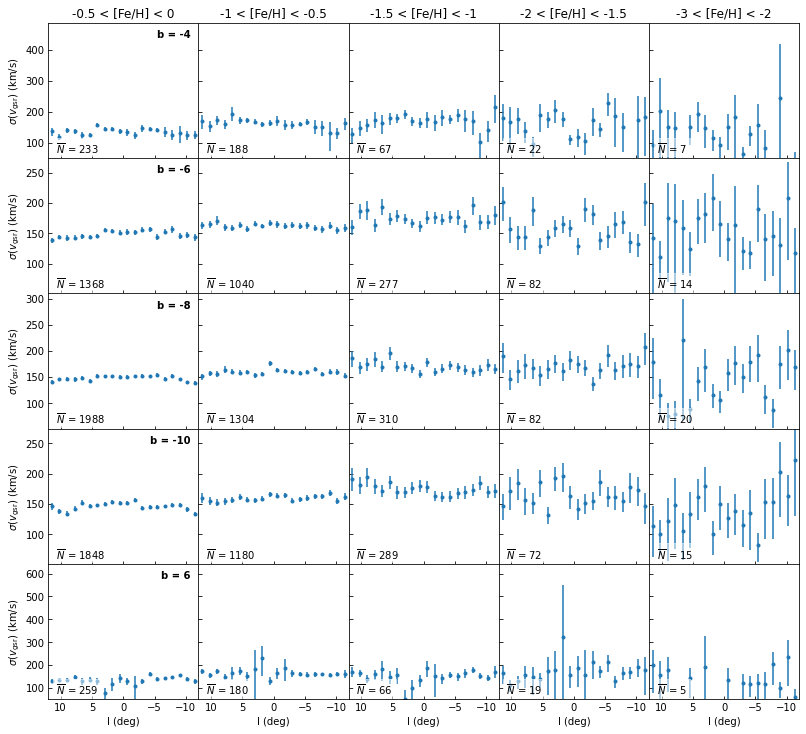

In [58]:
figax = plot_velocity_dispersions(strip_data)
fig, axs = figax

for n, ax in zip(bs, axs[:, 0]):
    txt = ax.texts[-1]
    txt.set_text(f"b = {n}")
    txt.set_fontweight('bold')

axs[1,0].set_ylim(51, 274)
axs[2,0].set_ylim(51, 310)
axs[3,0].set_ylim(51, 274)
plt.show()

### Other Halos

Using saved result...


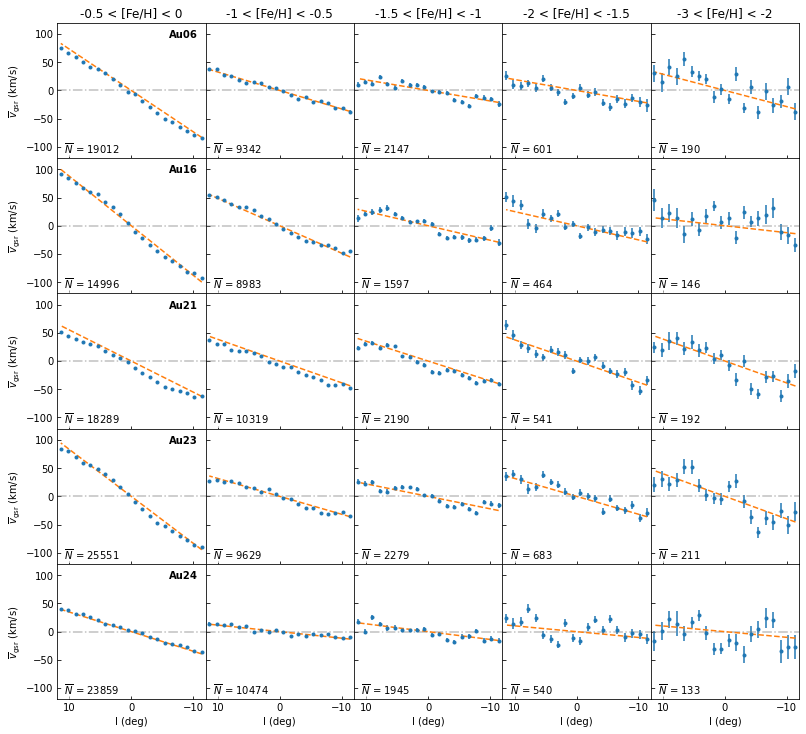

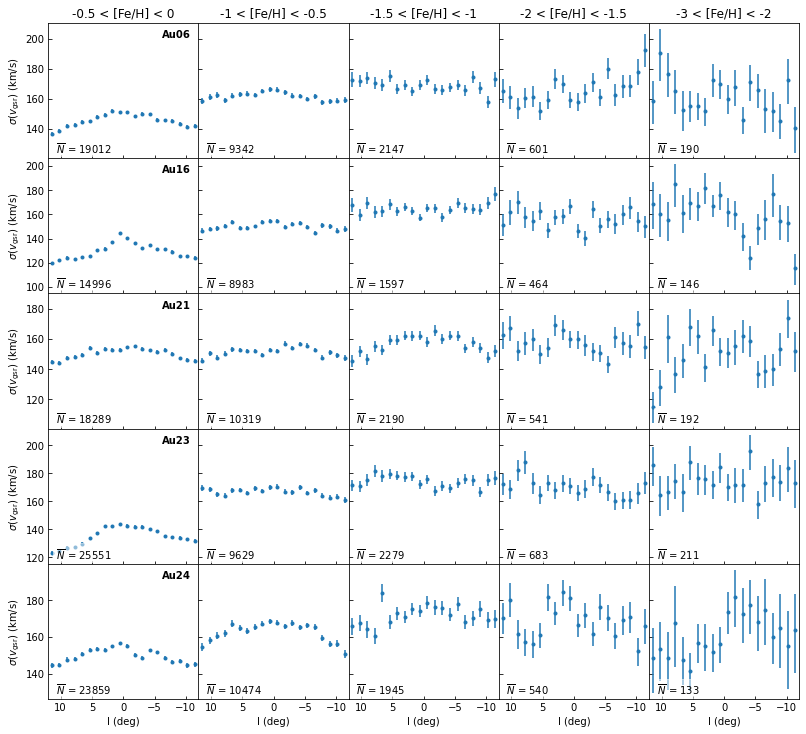

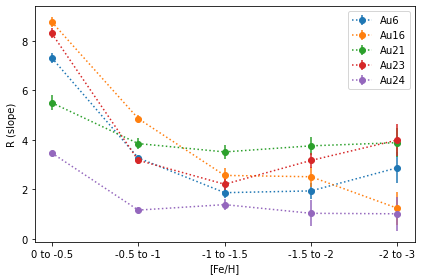

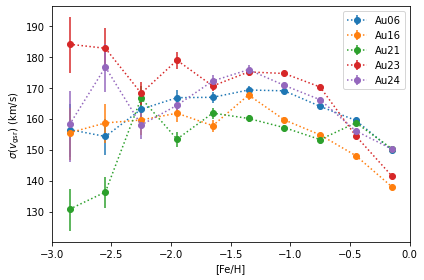

In [59]:
data = saveload("./data/computed/all_true_pos_velocity_stats.pkl", None)

fits = fit_flatness(data)

figax = plot_velocity_means(data)
plot_fits_lines(fits, data, figax)
plt.show()

fig, axs = plot_velocity_dispersions(data)

lim = axs[0,0].get_ylim()
axs[0,0].set_ylim(lim[0]+1, lim[1])

lim = axs[1,0].get_ylim()
axs[1,0].set_ylim(lim[0]-2, lim[1])

lim = axs[3,0].get_ylim()
axs[3,0].set_ylim(lim[0]-3, lim[1])

plt.show()


# plot_bin_sizes(data)
# plt.show()

plot_fits(fits)
plt.show()

plot_fe_dispersions(data)
plt.show()

Using saved result...


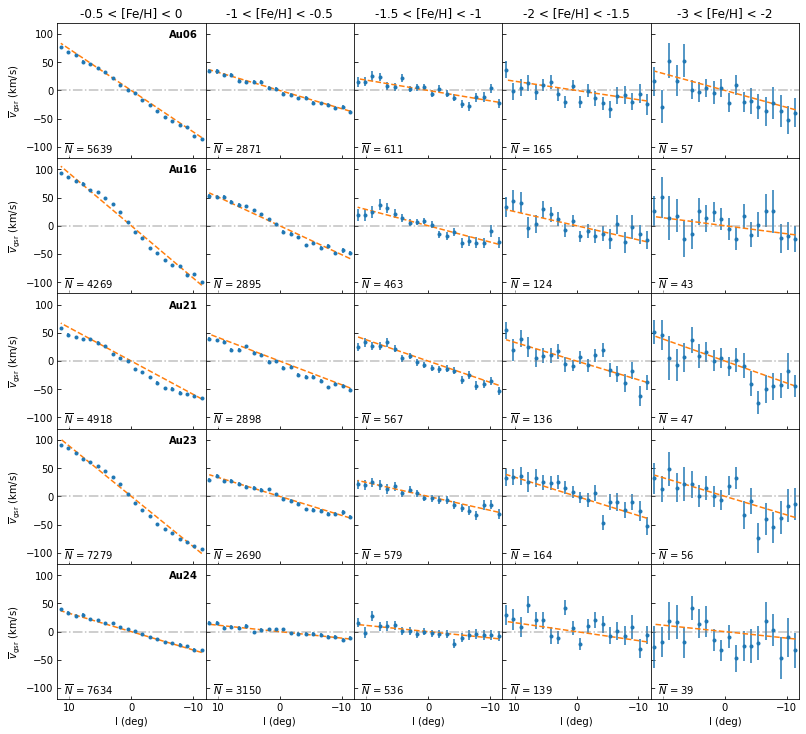

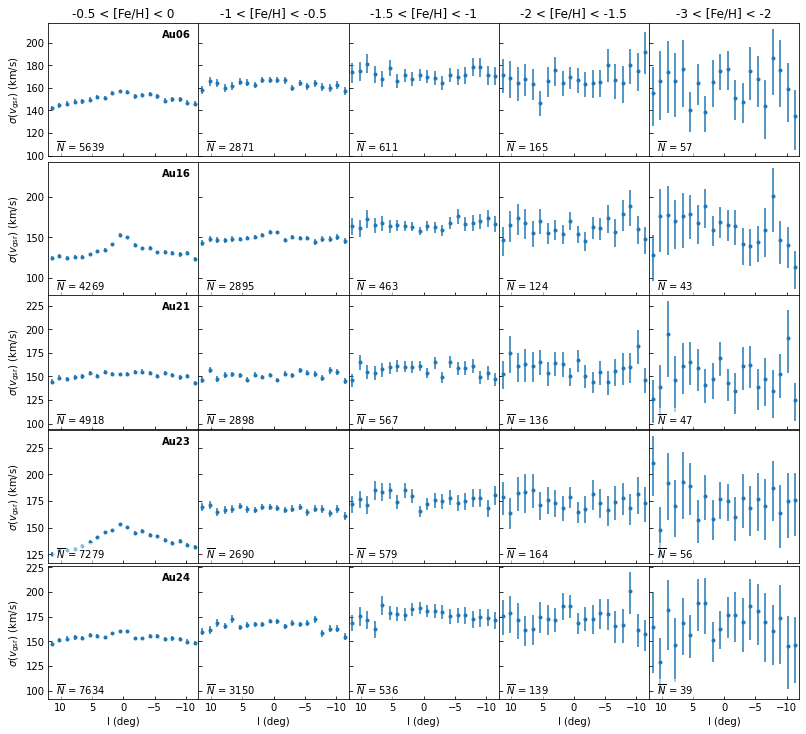

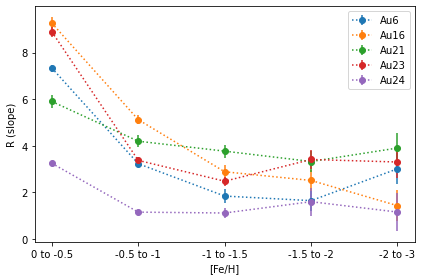

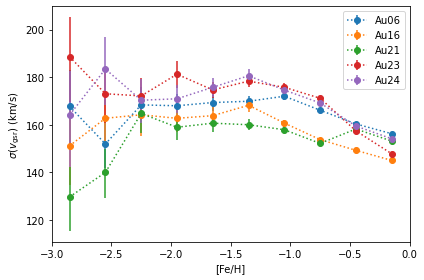

In [60]:
data = saveload("./data/computed/pid_velocity_stats.pkl", None)

fits = fit_flatness(data)

figax = plot_velocity_means(data)
plot_fits_lines(fits, data, figax)
plt.show()

fig, axs = plot_velocity_dispersions(data)
plt.show()

# plot_bin_sizes(data)
# plt.show()

plot_fits(fits)
plt.show()

plot_fe_dispersions(data)
plt.show()

### In-situ vs Accreted

Using saved result...
Using saved result...







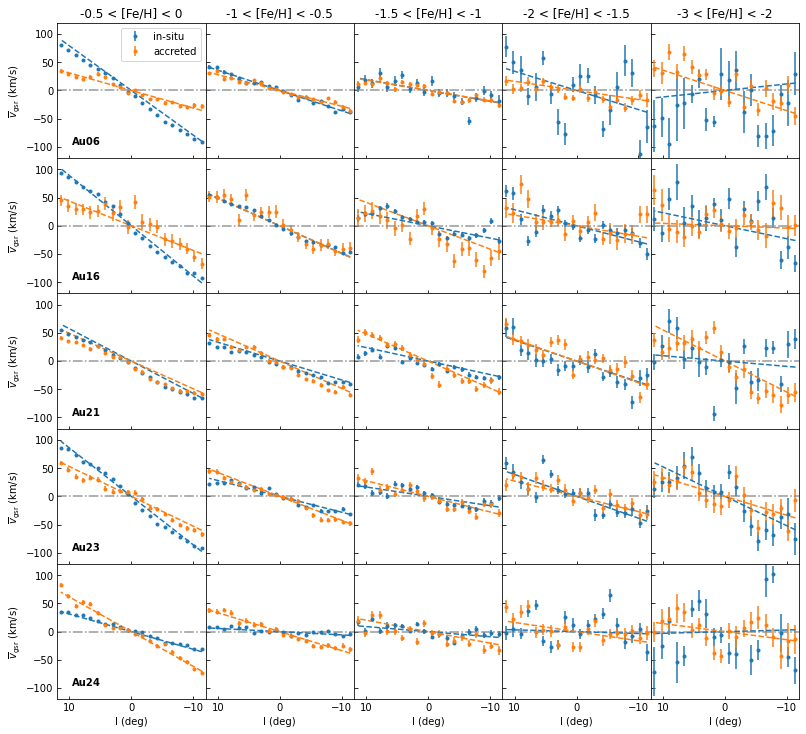

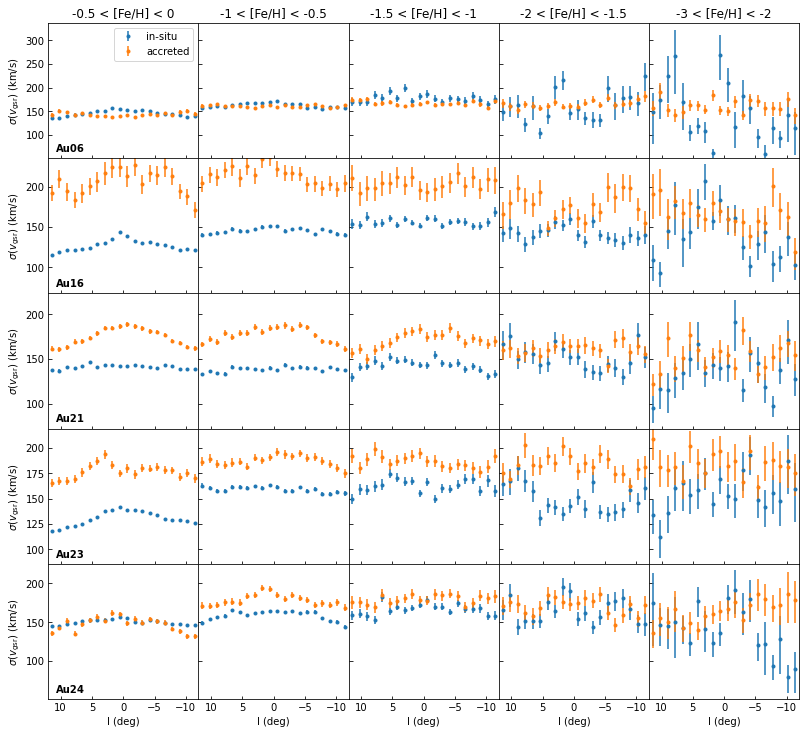

In [61]:
situ = saveload("./data/computed/insitu_velocity_stats.pkl", None)
accr = saveload("./data/computed/accreted_velocity_stats.pkl", None)

figax = plot_velocity_means(situ, plot_text=False)
plot_velocity_means(accr, figax=figax, plot_text=False)

situ_fits = fit_flatness(situ)
accr_fits = fit_flatness(accr)

fig, axs = figax
for n, axl in enumerate(axs):
    ax = axl[0]
    ax.legend()
    t1, t2 = ax.get_legend().get_texts()
    halo_name = t1.get_text()
    t1.set_text(f"in-situ")
    t2.set_text(f"accreted")
    print()
    ax.text(0.1, 0.1, halo_name, transform=ax.transAxes, fontweight='bold')
    if n != 0:
        ax.get_legend().set_visible(False)

plot_fits_lines(situ_fits, situ, figax, c='tab:blue')
plot_fits_lines(accr_fits, accr, figax, c='tab:orange')

plt.show()

figax = plot_velocity_dispersions(situ, plot_text=False)
plot_velocity_dispersions(accr, figax=figax, plot_text=False)

fig, axs = figax
for n, axl in enumerate(axs):
    ax = axl[0]
    ax.legend()
    t1, t2 = ax.get_legend().get_texts()
    halo_name = t1.get_text()
    t1.set_text(f"in-situ")
    t2.set_text(f"accreted")
    #     axl[0].text(10, 110, halo_name)
    ax.text(0.05, 0.05, halo_name, transform=ax.transAxes, fontweight='bold')
    if n != 0:
        ax.get_legend().set_visible(False)
        
lim = axs[0,0].get_ylim()
axs[0,0].set_ylim(lim[0]+1, lim[1])

plt.show()

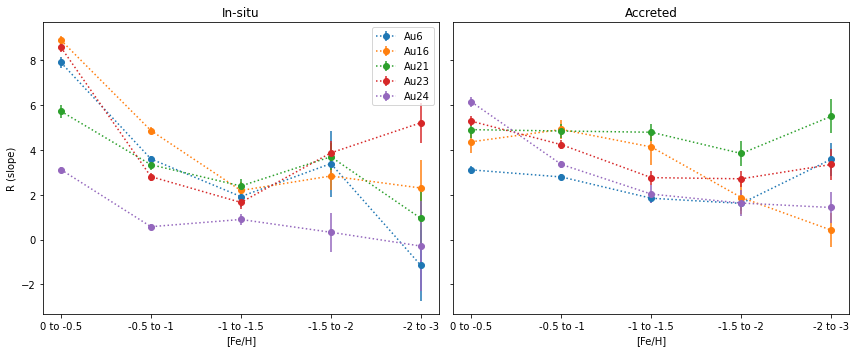

In [62]:
situ_fits = fit_flatness(situ)
accr_fits = fit_flatness(accr)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_fits(situ_fits, figax=(fig,axs[0]))
plot_fits(accr_fits, figax=(fig,axs[1]))

axs[1].get_legend().set_visible(False)
axs[1].set_ylabel('')

axs[0].set_title('In-situ')
axs[1].set_title('Accreted')

fig.tight_layout()

plt.show()

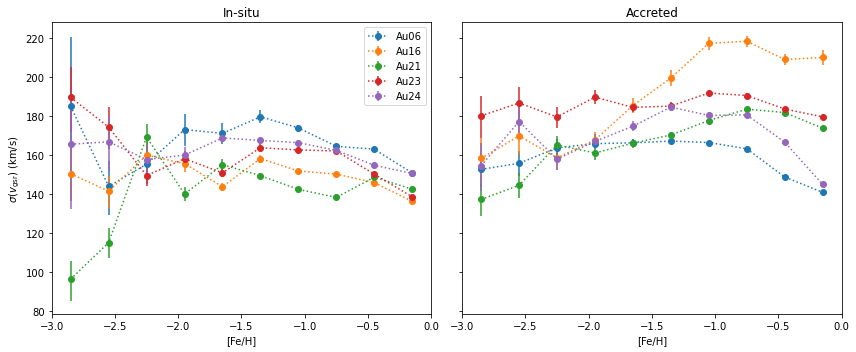

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_fe_dispersions(situ, figax=(fig,axs[0]))
plot_fe_dispersions(accr, figax=(fig,axs[1]))

axs[1].get_legend().set_visible(False)
axs[1].set_ylabel('')
axs[0].set_title('In-situ')
axs[1].set_title('Accreted')
fig.tight_layout()

plt.show()

### Age stuff

Using saved result...


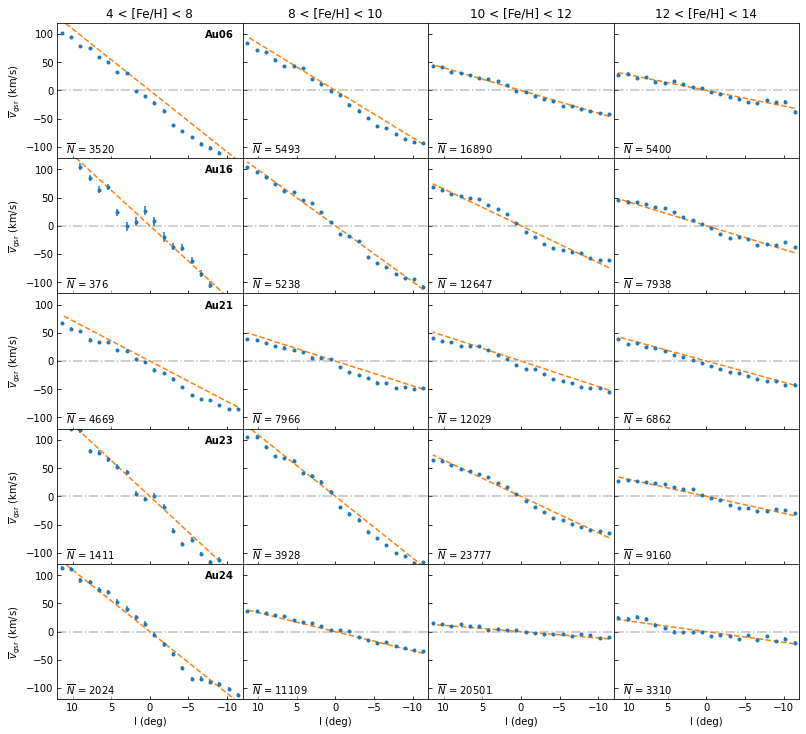

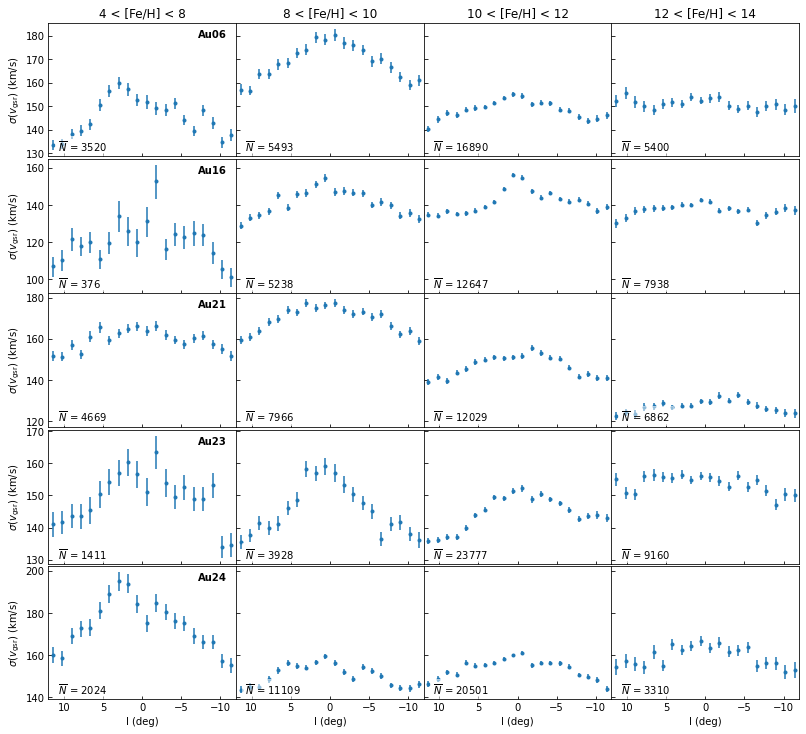

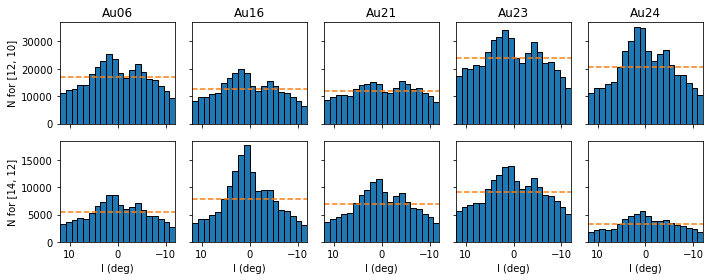

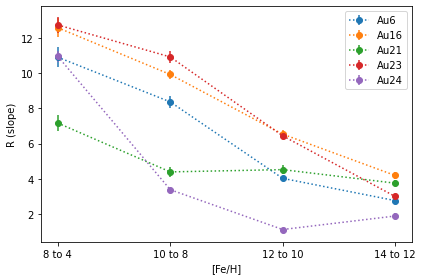

In [64]:
age_bins = [[4, 8], [8, 10], [10, 12], [12, 14]]

data = saveload("./data/computed/age_velocity_stats.pkl", None)

fits = fit_flatness(data)

figax = plot_velocity_means(data)
plot_fits_lines(fits, data, figax)
plt.show()

fig, axs = plot_velocity_dispersions(data)
plt.show()

plot_bin_sizes(data)
plt.show()

plot_fits(fits, bins=age_bins)
plt.show()

Using saved result...


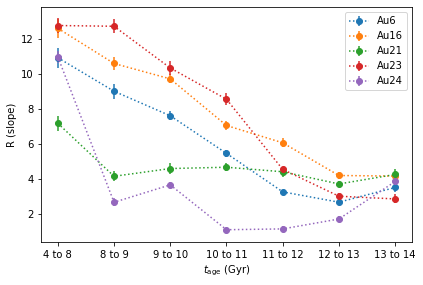

In [65]:
age_bins = [[4, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14]]
data = saveload("./data/computed/age_2_velocity_stats.pkl", None)
fits = fit_flatness(data)
fig, ax = plot_fits(fits, bins=age_bins)

ax.set_xticklabels(f"{l} to {r}" for l, r in age_bins)
ax.set_xlabel(r'$t_{\rm age}$ (Gyr)')
plt.show()

In [66]:
# Estimated from 'the prevalence of pseudobulges'
merger_times = {
    6: [9.5, 8.5, 6.8],
    16: [10, 7.5],
    21: [8.1, 8, 2.2], ## first two big mergers
    23: [4.2],
    24: [8.7, 8.8, 8.9, 4.3],
}

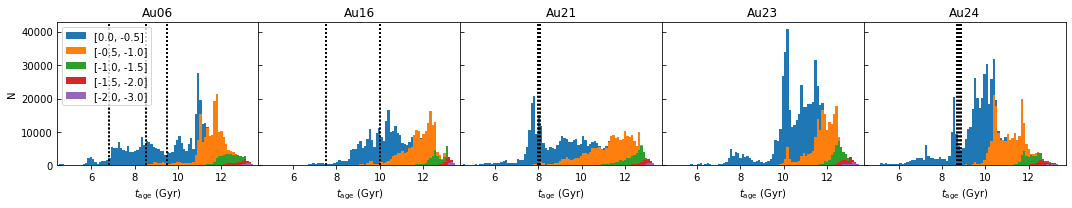

In [67]:
## Formation time of populations
bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]
sel = bulge_selection_2(4, z=1)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharey=True, squeeze=False)
for (h_nr, h), ax in zip(halo.items(), axs.flatten()):
    
    for b in bins:
        bin_str = f"(Fe_H > {b[0]}) & (Fe_H < {b[1]})"
        s = f"{sel} & {bin_str}"
        count = h.count(binby='Age', selection=s, limits=[0, 14], shape=130)
        bin_centers = h.bin_centers('', limits=[0, 14], shape=130)
        w = bin_centers[1] - bin_centers[0]
        ax.bar(bin_centers, count, width=w, label=f"[{b[1]:.1f}, {b[0]:.1f}]")
        for m in merger_times[h_nr]:
            ax.axvline(m, color='k', ls=':')

    ax.set_title(f"Au{h_nr:02d}")
    ax.set_xlim(4.4, 13.7)
    ax.tick_params(axis='y', direction='in')
    ax.set_xlabel(r'$t_{\rm age}$ (Gyr)')

axs[0, 0].set_ylabel('N')
axs[0, 0].legend(loc='upper left')
fig.tight_layout(w_pad=0)
plt.show()

### For all Halos

Using saved result...
Using saved result...
Using saved result...
Using saved result...
Using saved result...


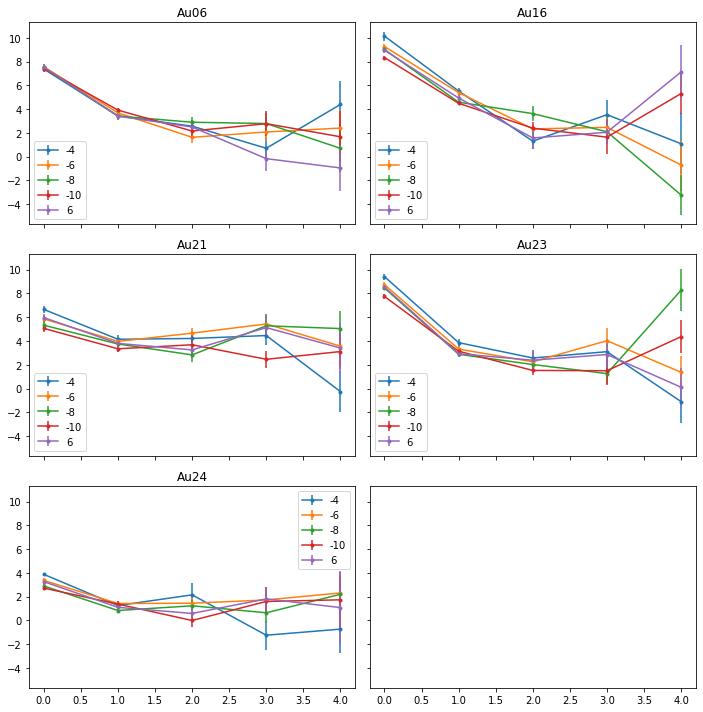

In [68]:
bs = [-4, -6, -8, -10, 6]
all_fits = {}
for h_nr in halo.keys():
    all_fits[h_nr] = np.empty((len(bs), 5, 2))
# all_fits = np.empty()
for n, b in enumerate(bs):
    sel = f"(b < {b+0.5}) & (b > {b-0.5}) & ({bulge_selection()})"
    data = saveload(f"./data/computed/slice_{b}_velocity_stats.pkl", halo, selection_str=sel)
    
    fits = fit_flatness(data)
    for k, v in fits.items():
        all_fits[k][n:n+2] = fits[k]

fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey=True, sharex=True)
for (h_nr, fits), ax in zip(all_fits.items(), axs.flatten()):
    
    for n, fit in enumerate(fits):
        ax.errorbar(np.arange(5), fit[:,0], yerr=fit[:,1], label=bs[n], marker='.')
    ax.set_title(f"Au{h_nr:02d}")
    ax.legend()
    
fig.tight_layout()

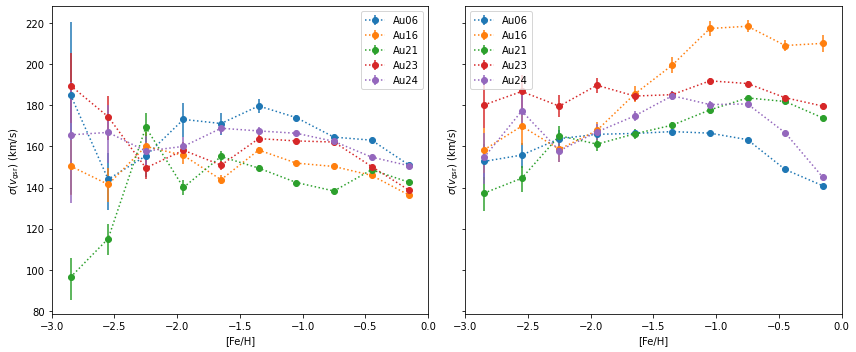

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_fe_dispersions(situ, figax=(fig,axs[0]))
plot_fe_dispersions(accr, figax=(fig,axs[1]))
fig.tight_layout()

plt.show()

## Tables

In [70]:
from astropy.table import QTable
from astropy.io import ascii as asci

In [71]:
def transpose_dicts(d):
    idxs = list(d.keys())
    keys = list(d[idxs[0]].keys())
    new_dict = {}
    for k in keys:
        new_dict[k] = [d[i][k] for i in idxs]
    if 'index' not in new_dict:
        new_dict['index'] = idxs
    return new_dict

In [72]:
t = QTable(transpose_dicts(mdata))
t['halo'] = ["Au{:02d}".format(i) for i in t['index']]
t

ErrorMonth,ErrorType,ExtinctionType,IMF,apparent_mag_band,apparent_mag_limit,apply_disk_cut,disk_cut_band,disk_cut_latitude,disk_cut_limit,solarazimuth,solarheight,solarradius,usun,vlsr,vsun,wsun,index,halo
float64,bytes9,bytes12,bytes8,bytes1,float64,int64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str4
22.0,GaiaError,NoExtinction,chabrier,V,20.0,1,V,20.0,16.0,30.0,2e-05,-0.008000000000000002,11.1,229.22258164519482,12.24,7.25,6,Au06
22.0,GaiaError,NoExtinction,chabrier,V,20.0,1,V,20.0,16.0,30.0,2e-05,-0.008000000000000002,11.1,213.5378191707707,12.24,7.25,16,Au16
22.0,GaiaError,NoExtinction,chabrier,V,20.0,1,V,20.0,16.0,30.0,2e-05,-0.008000000000000002,11.1,226.56830366726751,12.24,7.25,21,Au21
22.0,GaiaError,NoExtinction,chabrier,V,20.0,1,V,20.0,16.0,30.0,2e-05,-0.008000000000000002,11.1,234.61717398671792,12.24,7.25,23,Au23
22.0,GaiaError,NoExtinction,chabrier,V,20.0,1,V,20.0,16.0,30.0,2e-05,-0.008000000000000002,11.1,218.78741447670174,12.24,7.25,24,Au24


In [73]:
output = asci.Latex().write(t[('halo', 'vlsr')])
print('\n'.join(output))

\begin{table}
\begin{tabular}{cc}
halo & vlsr \\
Au06 & 229.22258164519482 \\
Au16 & 213.5378191707707 \\
Au21 & 226.56830366726751 \\
Au23 & 234.61717398671792 \\
Au24 & 218.78741447670174 \\
\end{tabular}
\end{table}


In [74]:
l, b = read_pointings('./data/fieldcenters_spec.csv')
for l, b in zip(l, b):
    print(f"{l:8.4f} & {b:8.4f} \\\\")

 -8.3400 &  10.2810 \\
 -2.6747 &   8.5868 \\
  7.4013 &  -8.2669 \\
 -3.0430 &  10.6548 \\
 -6.7530 &   8.7938 \\
 -5.3007 &  10.3496 \\
 -3.6258 &   5.3524 \\
  5.6931 &  -8.4823 \\
 10.0365 & -10.0418 \\
  8.6119 & -10.0540 \\
  5.3369 &  -9.9443 \\
  5.2928 &  -6.6449 \\
  6.7759 &  -7.2137 \\
  2.4711 &  -5.1224 \\
  5.3122 &  -4.0879 \\
  6.6103 & -10.8908 \\
  3.3348 &  -3.3600 \\
  1.4733 &  -3.7986 \\
  3.5425 &  -7.5296 \\
  4.8560 &  -4.8393 \\
  7.1027 &  -5.2878 \\


## Other Plots

Saving at figs/Teff-logg.png


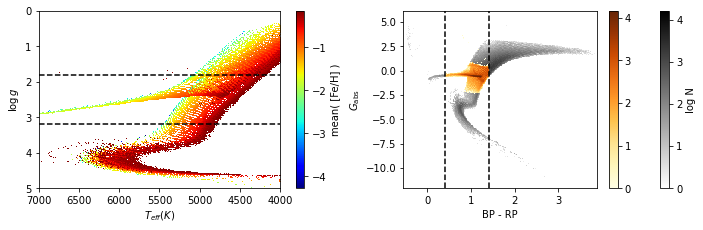

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(10,3.3))

h_nr = 6
h = halo[6]

ax = axs[0]
plot_grav_teff(h, ax)
ax.axhline(1.8, ls='--', c='k')
ax.axhline(3.2, ls='--', c='k')

ax = axs[1]
plt.sca(ax)
plot_CMD(h, ax, colormap='binary', colorbar_label='log N')
plot_CMD(h, ax, selection=observational_selection(), colorbar_label=' ')
ax.set_ylabel(r'$G_{\rm abs}$')
ax.set_xlabel('BP - RP')
ax.axvline(0.4, ls='--', c='k')
ax.axvline(1.4, ls='--', c='k')

save_show('Teff-logg.png')

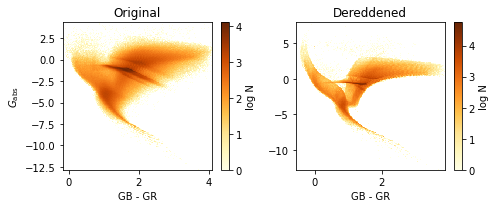

In [76]:
h, m = open_halo(6, selection=False)

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs = axs.flatten()

ax = axs[0]
plt.sca(ax)
h.viz.heatmap('GBmagnitude - GRmagnitude',
                   '-GabsMagnitude',
                   f='log10',
                   colormap='YlOrBr',
                   colorbar_label='log N')
ax.set_title('Original')

ax = axs[1]
plt.sca(ax)
h.viz.heatmap('GBmagnitudeDR - GRmagnitudeDR',
                   '-GabsMagnitudeDR',
                   f='log10',
                   colormap='YlOrBr',
                   colorbar_label='log N')
ax.set_title('Dereddened')

for ax in axs:
    ax.set_xlabel('GB - GR')
    ax.set_ylabel(r'$G_{\rm abs}$')
    
axs[1].set_ylabel('')

fig.tight_layout()
plt.show()

In [77]:
sel = bulge_selection_2(4, z=1)
for h_nr, h in halo.items():
    a = h.count(selection=f'(AccretedFlag==-1) & {sel}')
    b = h.count(selection=f'(AccretedFlag==0) & {sel}')
    c = h.count(selection=f'(AccretedFlag==1) & {sel}')
    frac = b/(a+b) # accreted
    print(f"{h_nr:02d} | {frac:.3f}")

06 | 0.306
16 | 0.049
21 | 0.290
23 | 0.154
24 | 0.132


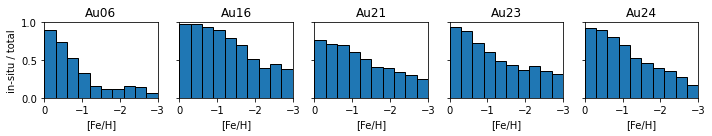

In [78]:
fig, axs = plt.subplots(1, len(halo), figsize=(2*len(halo), 2), sharey=True, sharex=True)

for (h_nr, h), ax in zip(halo.items(), axs):
    frac = h.mean('AccretedFlag', binby='Fe_H', limits=[-3, 0], shape=10, selection=bulge_selection_2(4, z=1))
    fe = h.bin_centers('', limits=[-3, 0], shape=10)

    ax.bar(fe, -frac, width=fe[1] - fe[0], ec='k')
    ax.set_title(f"Au{h_nr:02d}")
    ax.set_xlabel('[Fe/H]')

axs[0].set_ylim(0, 1)
axs[0].set_xlim(-3, 0)
axs[0].set_ylabel(r'in-situ / total')
axs[0].invert_xaxis()
fig.tight_layout()
    
plt.show()

In [79]:
x = h.bin_centers('', limits=[-3, 0], shape=10)
x[1] - x[0]

0.2999999999999998

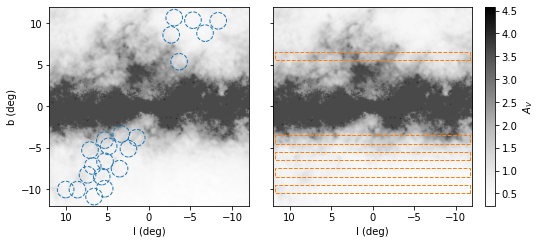

In [80]:
from matplotlib.patches import Circle, Rectangle

h = halo[6]

# sel = observational_selection(obs=False)
sel = 'Parallax < 0.00025'

pixels = h.mean('Extinction31', binby=['l_wrap', 'b'], limits=(-12, 12), shape=200, selection=sel)
pixels[np.isnan(pixels)] = np.nanmax(pixels) - 1
ls, bs = read_pointings('./data/fieldcenters_spec.csv')

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

for ax in axs:
    im = ax.imshow(pixels.T, origin='lower', cmap='Greys', extent=[-12, 12, -12, 12], interpolation='bicubic')

ax = axs[0]
for l, b in zip(ls, bs):
    c = Circle((l, b), radius=1, fill=False, edgecolor='tab:blue', ls='--')
    ax.add_patch(c)
    
ax = axs[1]
bs = [-4, -6, -8, -10, 6]
db = 0.5
eps = 0.3
for b in bs:
    box = Rectangle((-12+eps, b-db), 24-2*eps, 2*db, ls='--', fill=False, edgecolor='tab:orange')
    ax.add_patch(box)

fig.colorbar(im, ax=ax, label=r'$A_V$')

axs[0].set_ylabel('b (deg)')
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlabel('l (deg)')

# TODO split these into two plots (will probably look nicer)
fig.tight_layout(w_pad=0.01)

plt.show()

## Playground

In [81]:
h = halo[6]
m = mdata[6]

In [82]:
h.max('Age')

array(13.585968, dtype=float32)

### G vs Gobs

In [83]:
h = halo[6]
gmin, gmax = 13.5, 16.5
sel = f'(Gmagnitude > {gmin}) & (Gmagnitude < {gmax})'
sel_obs = f'(GmagnitudeObs > {gmin}) & (GmagnitudeObs < {gmax})'
sel_dr = f'(GmagnitudeDR > {gmin}) & (GmagnitudeDR < {gmax})'
normal = h.count()
obs = h.count(selection=sel_obs)
dr = h.count(selection=sel_dr)
print((1 - (obs / normal))*100)

0.005740202487336532


0.42296580730207783
0.025000000000000355


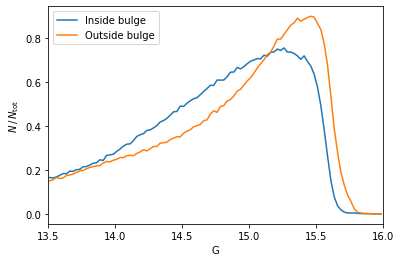

In [84]:
sel = bulge_selection_2(4, z=1.0)
a = h.count(selection=sel)
b = h.count(selection=f"~({sel})")
print(a / (a + b))
c1 = h.count(binby='Gmagnitude', limits=[13.5, 16.0], shape=100, selection=sel)
c2 = h.count(binby='Gmagnitude', limits=[13.5, 16.0], shape=100, selection=f"~({sel})")

xs = h.bin_centers('', (13.5, 16.0), 100)
bin_w = xs[1] - xs[0]
print(bin_w)

fig, ax = plt.subplots(1, 1)
c1 = c1 / (c1.sum()*bin_w)
c2 = c2 / (c2.sum()*bin_w)

ax.plot(xs, c1, label='Inside bulge')
ax.plot(xs, c2, label='Outside bulge')
ax.set_xlim(13.5, 16.0)
# ax.set_yticks([])
ax.set_ylabel(r'$N \,/\, N_{\rm tot}$')
ax.set_xlabel('G')
ax.legend()

plt.show()

### Distance Selection

626321


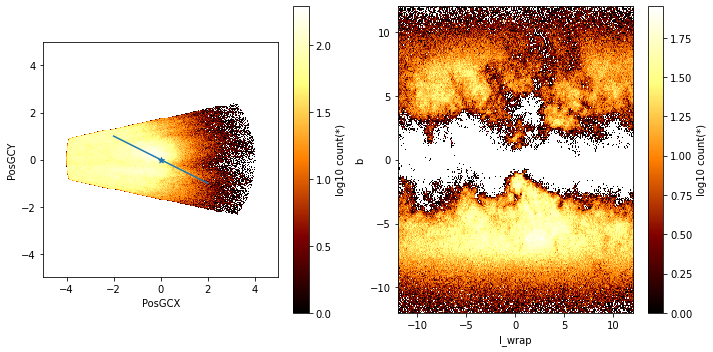

In [85]:
sel = bulge_selection_2(4, z=1.0)
# sel = observational_selection()
# sel = observational_selection() + "& (ParallaxObs < 0.00025)"
print(h.count(selection=sel))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax[0])
h.viz.heatmap('PosGCX', 'PosGCY', what='count(*)', f='log10', limits=[-5, 5], selection=sel, aspect=1)
plt.sca(ax[1])
h.viz.heatmap('l_wrap', 'b', what='count(*)', f='log10', selection=sel)

# bar orientation
x = np.linspace(-2, 2)
y = np.sin(-np.radians(30))*x
ax[0].plot(x, y)
ax[0].scatter(0, 0, marker='*')
plt.show()

### Comparing G and V

277543


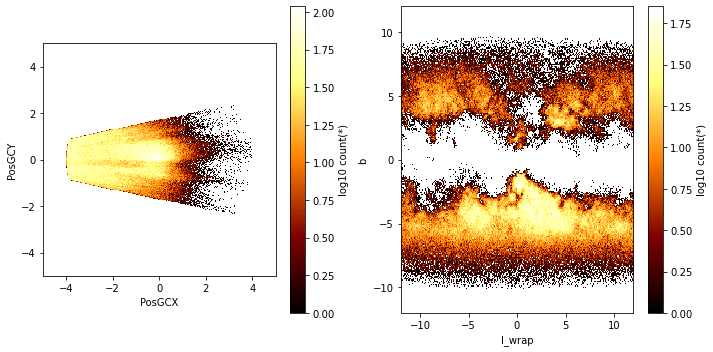

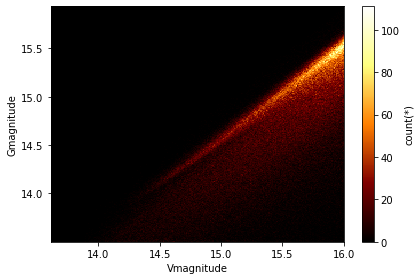

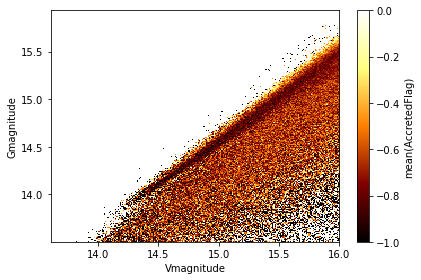

In [86]:
sel = bulge_selection_2(4, z=0.7)
print(h.count(selection=sel))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax[0])
h.viz.heatmap('PosGCX', 'PosGCY', what='count(*)', f='log10', limits=[-5, 5], selection=sel, aspect=1)
plt.sca(ax[1])
h.viz.heatmap('l_wrap', 'b', what='count(*)', f='log10', selection=sel)
plt.show()

h.viz.heatmap('Vmagnitude', 'Gmagnitude', what='count(*)', selection=sel)
plt.show()
h.viz.heatmap('Vmagnitude', 'Gmagnitude', what='mean(AccretedFlag)', selection=sel)
plt.show()

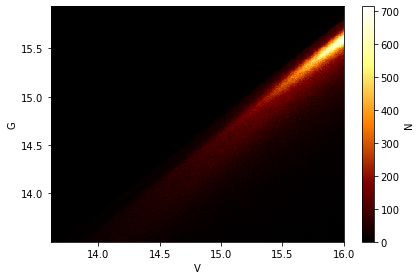

In [87]:
sel = bulge_selection_2(4, z=1)
h.viz.heatmap('Vmagnitude', 'Gmagnitude', what='count(*)', selection=None, xlabel='V', ylabel='G', colorbar_label='N')
plt.show()

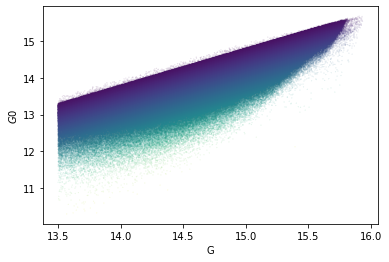

In [88]:
sel = bulge_selection_2(4, z=1)
h.viz.scatter('Gmagnitude',
              'GmagnitudeDR',
              selection=None,
              xlabel='G',
              ylabel=r'$G0$',
              marker='.',
              c_expr='Extinction31',
              s=0.01,
              length_check=False)
plt.show()

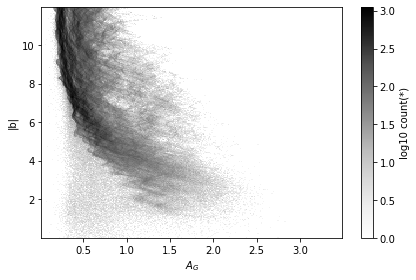

In [89]:
h.viz.heatmap('Extinction31*0.718',
              'abs(b)',
              what='count(*)',
              xlabel=r'$A_G$',
              ylabel='|b|',
              f='log10',
              colormap='Greys')
plt.show()

### Joining with snapshot

In [90]:
snap = vaex.open('./data/snapshot_halo_06_custom.hdf5')
with vaex.progress.tree('rich', title='Joining datasets'):
    au6 = halo[6].join(snap, left_on='ParticleID', right_on='ParticleIDs', rprefix='SNAP_')

Output()

In [91]:
au6.info()

column,type,unit,description,expression
AccretedFlag,float32,,,
Age,float32,,,
Bmagnitude,float32,,,
Dec,float32,,,
DecError,float32,,,
DecObs,float32,,,
EffectiveTemperature,float32,,,
EffectiveTemperatureError,float32,,,
EffectiveTemperatureObs,float32,,,
Extinction31,float32,,,


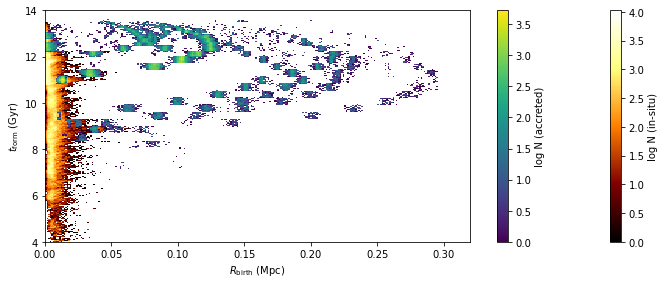

In [92]:
au6['BirthR'] = 'sqrt(XBirthPos**2 + YBirthPos**2 + ZBirthPos**2)'
au6['BirthRCylinder'] = 'sqrt(XBirthPos**2 + YBirthPos**2)'
lim = [[0, 0.30], [4, 14]]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.sca(ax)
au6.viz.heatmap('BirthR', 'Age', limits=lim, f='log10', selection='AccretedFlag==-1', colorbar_label='log N (in-situ)')
au6.viz.heatmap('BirthR', 'Age', limits=lim, f='log10', selection='AccretedFlag==0', colormap='viridis', colorbar_label='log N (accreted)')
ax.set_xlim(0, 0.32)
ax.set_ylim(4, 14)
ax.set_xlabel(r'$R_{\rm birth}$ (Mpc)')
ax.set_ylabel(r'$t_{\rm form}$ (Gyr)')
# fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
plt.show()

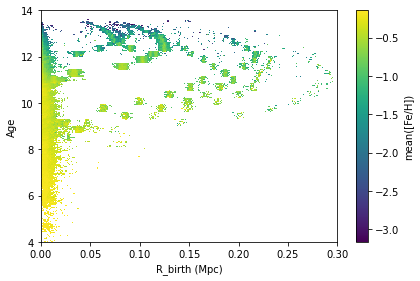

In [93]:
sel = bulge_selection_2(4, z=1)
fig, ax = plt.subplots(1, 1)
plt.sca(ax)
au6.viz.heatmap('BirthR',
                'Age',
                what='mean(Fe_H)',
                colormap='viridis',
                selection=f'({sel}) & (Z < 0) & (Z > -3)',
                limits=[[0, 0.30], [4, 14]],
                colorbar_label='mean([Fe/H])')
ax.set_xlabel('R_birth (Mpc)')
plt.show()

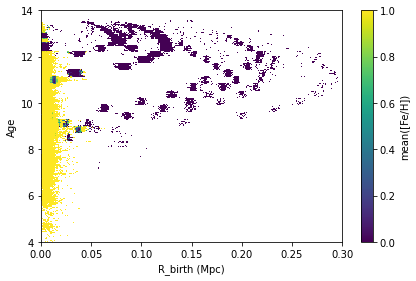

In [94]:
sel = bulge_selection_2(4, z=1)
fig, ax = plt.subplots(1, 1)
plt.sca(ax)
au6.viz.heatmap('BirthR',
                'Age',
                what='mean(-AccretedFlag)',
                colormap='viridis',
                selection=f'({sel}) & (Z < 0) & (Z > -3)',
                limits=[[0, 0.30], [4, 14]],
                colorbar_label='mean([Fe/H])')
ax.set_xlabel('R_birth (Mpc)')
plt.show()

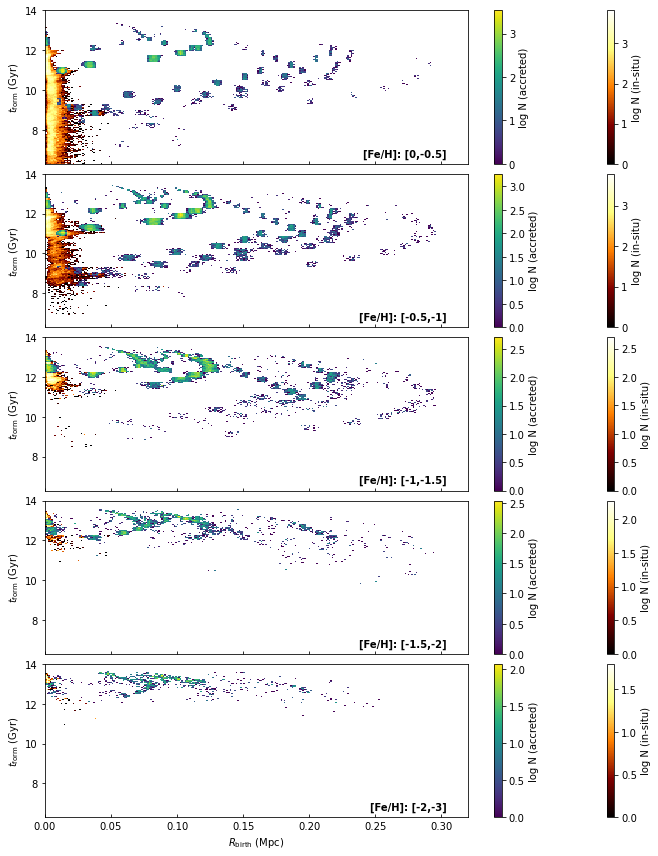

In [95]:
bins = [[-0.5, 0], [-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
for ax, b in zip(axs.flatten(), bins):
    lim = [[0, 0.30], [4, 14]]
    plt.sca(ax)
    sel = f'(Fe_H > {b[0]}) & (Fe_H <= {b[1]})'
    au6.viz.heatmap('BirthR', 'Age', limits=lim, f='log10', selection=f'(AccretedFlag==-1) & {sel}', colorbar_label='log N (in-situ)')
    au6.viz.heatmap('BirthR', 'Age', limits=lim, f='log10', selection=f'(AccretedFlag== 0) & {sel}', colormap='viridis', colorbar_label='log N (accreted)')
    ax.set_xlim(0, 0.32)
    ax.set_ylim(6.3, 14)
    ax.set_ylabel(r'$t_{\rm form}$ (Gyr)')
    ax.set_xlabel('')
    ax.text(0.95, 0.1, f"[Fe/H]: [{b[1]},{b[0]}]",
                    ha='right',
                    va='top',
                    fontweight='bold', transform=ax.transAxes)
    ax.tick_params(axis='x', direction='in')
    
axs[-1].set_xlabel(r'$R_{\rm birth}$ (Mpc)')
fig.tight_layout(h_pad=0)
plt.show()